In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [59]:
OUTDIR = 'output'

if not os.path.isdir(OUTDIR):
    os.makedirs(OUTDIR)
    

In [2]:
import textwrap
from matplotlib.lines import Line2D

Duomenų pravalymas

In [3]:
data = pd.read_csv('../data/data.tsv', sep='\t')
# "Neturiu nuomonės" should be NaN
data = data[data['answer'] != 'Neturiu nuomonės']
data = data.set_index(['party', 'member_name', 'question'])

Atsakymus galima užkoduoti gana patogiai nuo -2 iki 2:

In [4]:
ORDERED_ANSWERS = ['Visiškai nesutinku',
                   'Greičiau nesutinku',
                   'Nei taip, nei ne',
                   'Greičiau sutinku',
                   'Visiškai sutinku', 
                   ]
ORDERED_ANSWER_CODES = [-2, -1, 0, 1, 2]
CODES = dict(zip(ORDERED_ANSWERS, ORDERED_ANSWER_CODES))
data['answer_code'] = data['answer'].apply(lambda x: CODES[x])

In [5]:
ORDERED_ANSWERS_FOR_LABELS = [ans.replace(' ', '\n') if ans != 'Nei taip, nei ne' else 'Nei taip,\nnei ne' for ans in ORDERED_ANSWERS]

Partijos, kurias turim. Sugrupuokim mažąsias partijas (ne daugiau 5 narių):

In [6]:
party_sizes = data.reset_index().groupby('party')['member_name'].nunique()
small_parties = party_sizes[party_sizes <= 5].index

In [7]:
data['grouped_party'] = data.index.get_level_values('party')
data.loc[data['grouped_party'].isin(small_parties), 'grouped_party'] = "Kitos partijos"

data = data.reset_index().set_index(['grouped_party', 'member_name', 'question'])

In [8]:
parties = data.reset_index()['grouped_party'].unique()

In [9]:
PARTY_COLOR = {
    'Laisvės partija': '#E9366D',
    'Tėvynės sąjunga - Lietuvos krikščionys demokratai': '#3A599C',
    'Lietuvos valstiečių ir žaliųjų sąjunga': '#42944F',
    'Lietuvos žaliųjų partija': '#9EC655',
    'Lietuvos Respublikos liberalų sąjūdis': '#D39842',
    'Centro partija – tautininkai': '#AEDAB2', 
    'Lietuvos socialdemokratų partija': '#C94441',
    'Krikščionių sąjunga': '#F3AD61', 
    'Nacionalinis susivienijimas': '#A03735',
    'Darbo partija': '#101876', 
    'Lietuvos sąrašas': '#87190F', 
    'Nepriklauso jokiai partijai': '#666666',
    'Lietuvos liaudies partija': '#E1AC59',
    'Kitos partijos': '#666666',
}

Klausimų eiga pagal variaciją:

In [10]:
variance_order = list(data.groupby('question')['answer_code'].var().sort_values(ascending=False).index)

Klausimai su didžiausia variacija

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


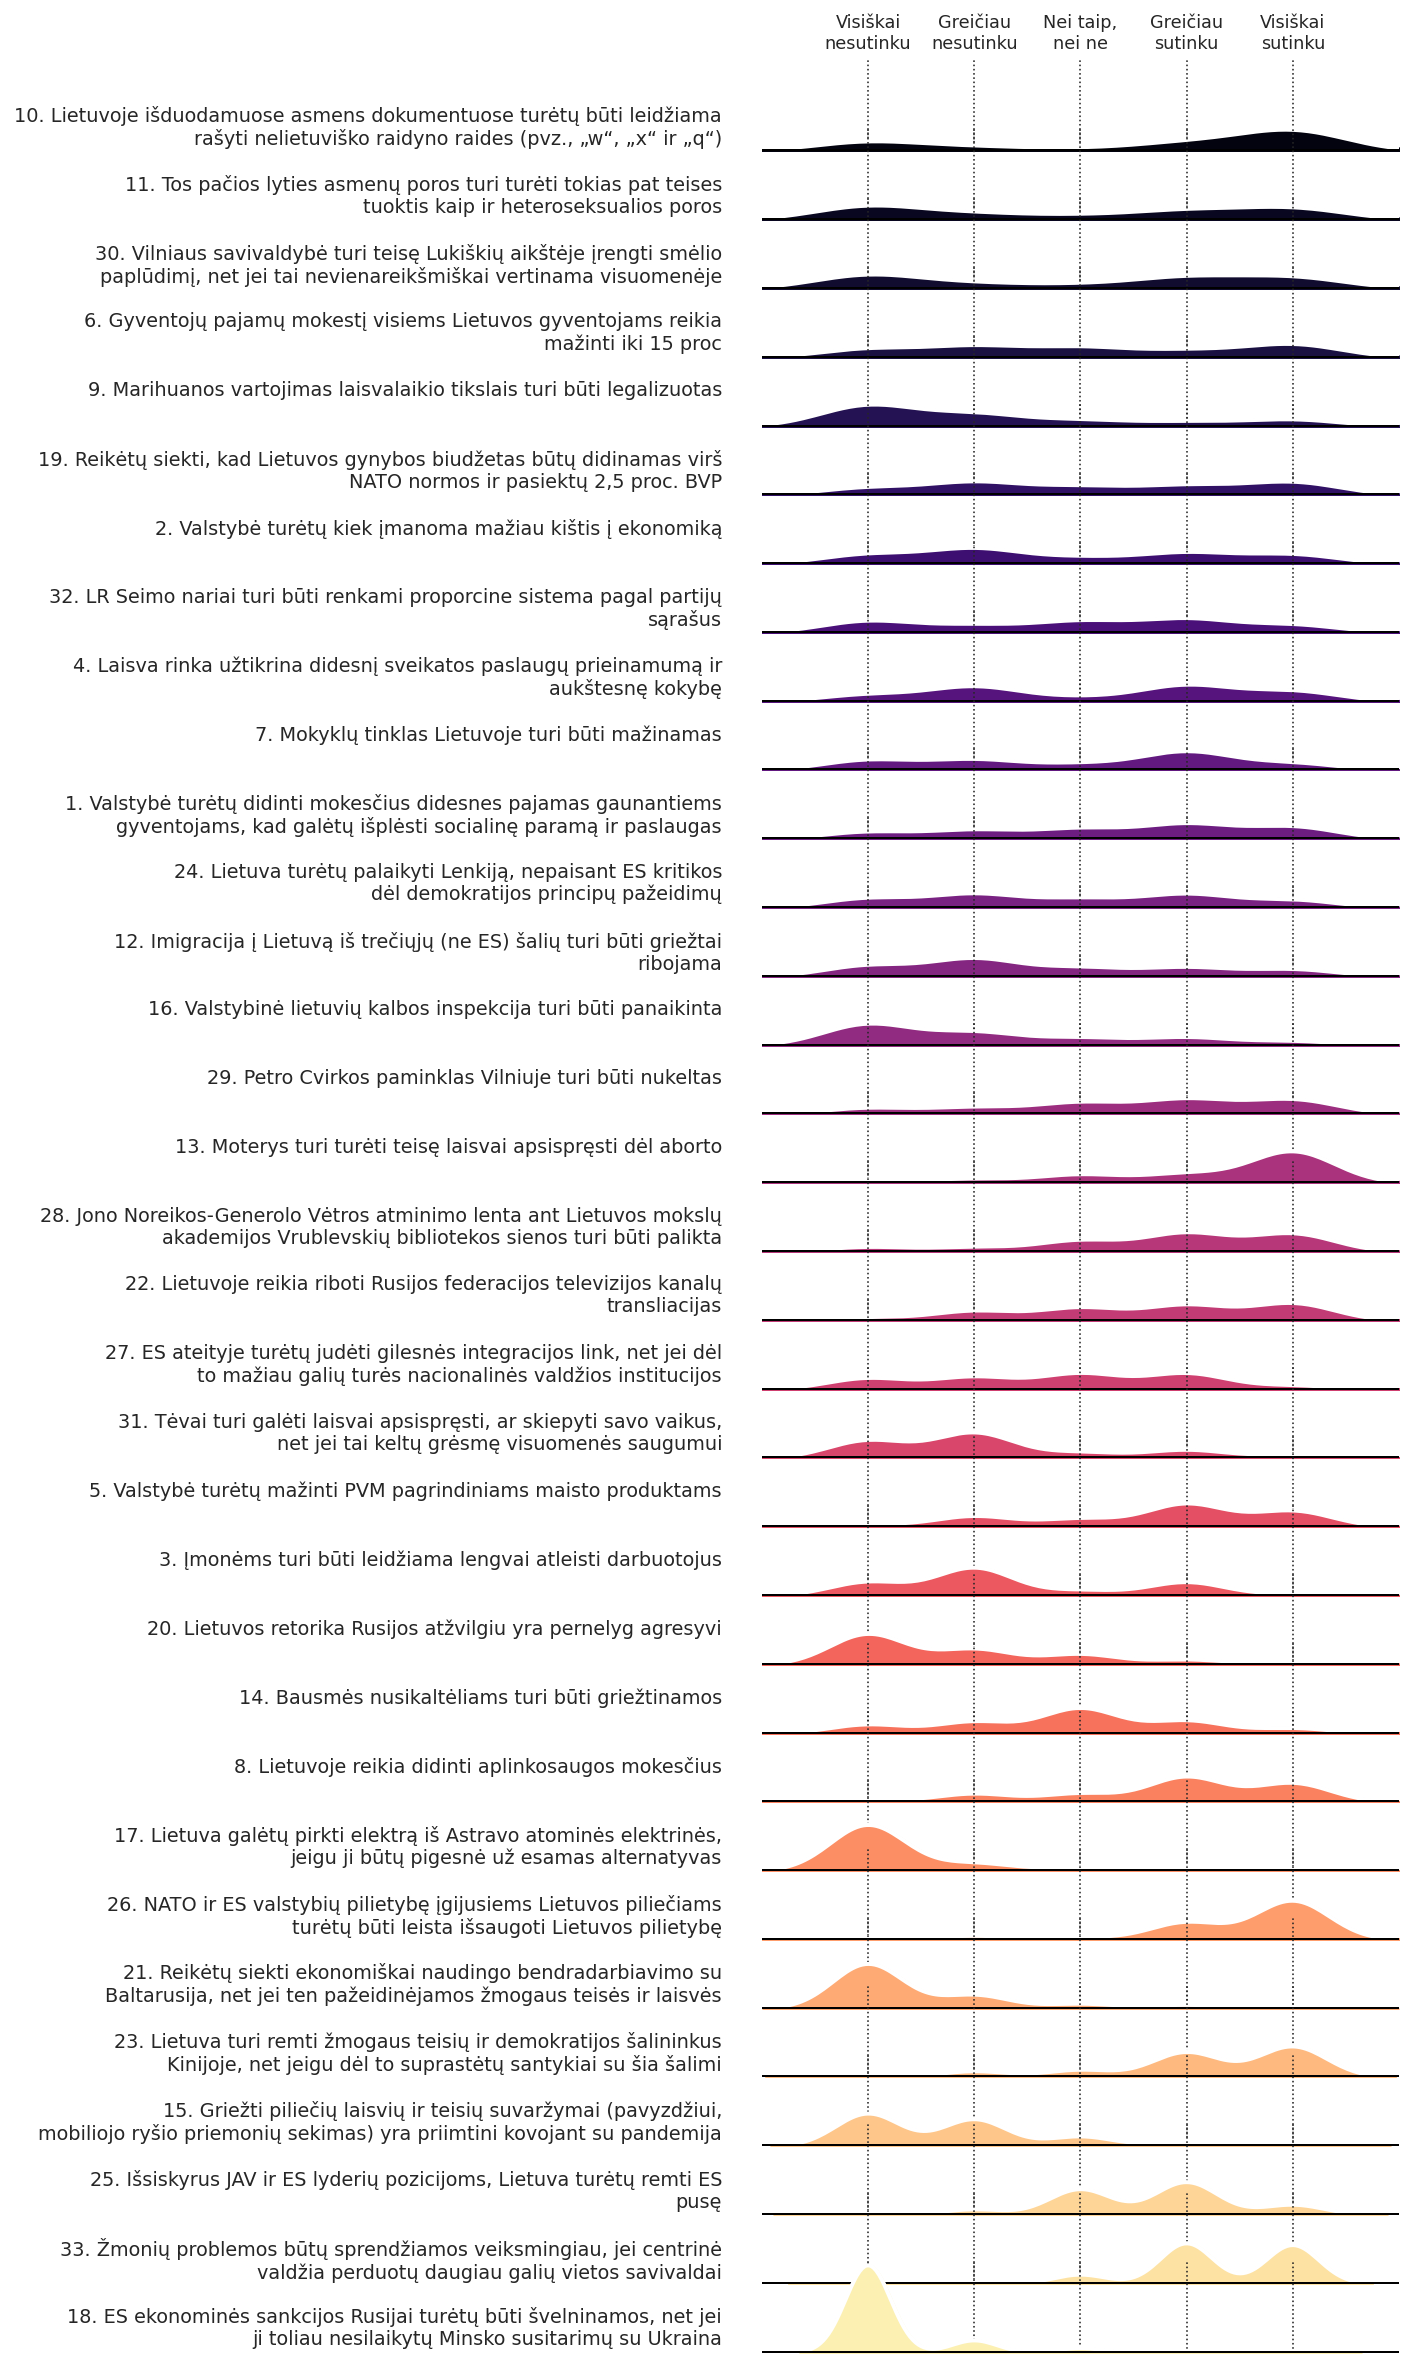

In [11]:
_df = data.reset_index()

x_order = variance_order

fgrid = sns.FacetGrid(data=_df, row='question', 
                      hue='question',
                      palette='magma',
                      row_order=x_order, 
                      hue_order=x_order,
                      aspect=10, height=0.5, sharex=False)

kde_kwargs = dict()
fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=True, alpha=1, linewidth=1.5, **kde_kwargs)

fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=False, 
          color="w", linewidth=2.0, 
          **kde_kwargs)


fgrid.set_titles(row_template='{row_name}', col_template='')



for i, ax in enumerate(fgrid.axes.ravel()):
    label = ax.get_title()
    ax.set_ylabel('\n'.join(textwrap.wrap(label, 70)), 
                  rotation='horizontal', ha='right', va='top', labelpad=20)
    ax.set_title('')
    ax.yaxis.grid(False)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    
    ax.set_xlim([-3, 3])
    ax.set_xticks(ORDERED_ANSWER_CODES)
    
    ax.axhline(0, linestyle='-', color='black', linewidth=2)
    
    if i == 0:
        ax.xaxis.tick_top()
        ax.set_xticklabels(ORDERED_ANSWERS_FOR_LABELS)
    else:
        for tick in ax.get_xticklabels():
            tick.set_visible(False)
            
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlabel('')
    ax.patch.set_alpha(0)
    
fgrid.fig.subplots_adjust(hspace=-0.25)
fgrid.savefig(os.path.join(OUTDIR, 'klausimai-pagal-nesutarima.pdf'))

Only the top few:

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


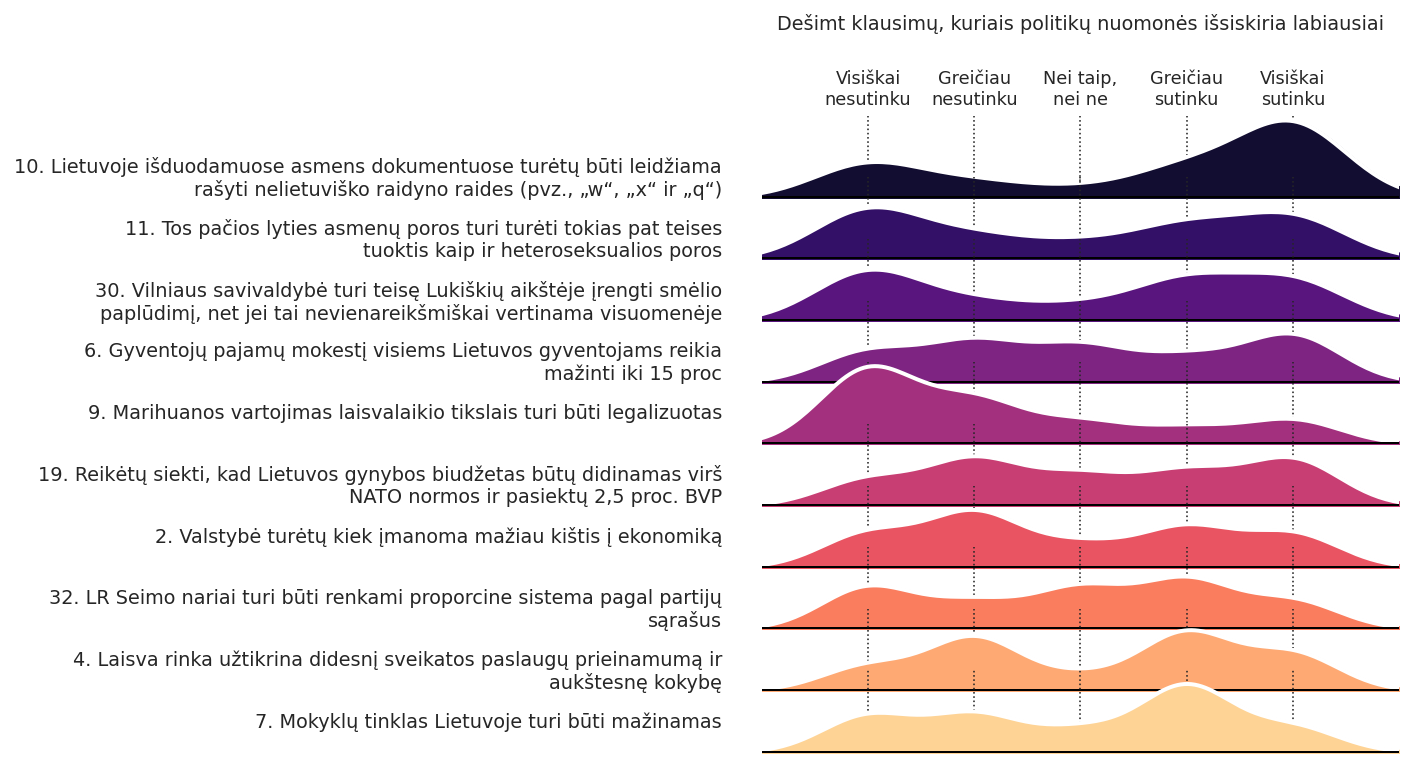

In [12]:
_df = data.reset_index()

x_order = variance_order[:10]

fgrid = sns.FacetGrid(data=_df, row='question', 
                      hue='question',
                      palette='magma',
                      row_order=x_order, 
                      hue_order=x_order,
                      aspect=10, height=0.5, sharex=False)

kde_kwargs = dict()
fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=True, alpha=1, linewidth=1.5, **kde_kwargs)

fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=False, 
          color="w", linewidth=2.0, 
          **kde_kwargs)


fgrid.set_titles(row_template='{row_name}', col_template='')



for i, ax in enumerate(fgrid.axes.ravel()):
    label = ax.get_title()
    ax.set_ylabel('\n'.join(textwrap.wrap(label, 70)), 
                  rotation='horizontal', ha='right', va='top', labelpad=20)
    ax.set_title('')
    ax.yaxis.grid(False)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    
    ax.set_xlim([-3, 3])
    ax.set_xticks(ORDERED_ANSWER_CODES)
    
    ax.axhline(0, linestyle='-', color='black', linewidth=2)
    
    if i == 0:
        ax.xaxis.tick_top()
        ax.set_xticklabels(ORDERED_ANSWERS_FOR_LABELS)
        ax.set_title("Dešimt klausimų, kuriais politikų nuomonės išsiskiria labiausiai", pad=20)
    else:
        for tick in ax.get_xticklabels():
            tick.set_visible(False)
            
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlabel('')
    ax.patch.set_alpha(0)
    
fgrid.fig.subplots_adjust(hspace=-0.25)
fgrid.savefig(os.path.join(OUTDIR, 'klausimai-pagal-nesutarima-top10.pdf'))

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make ax

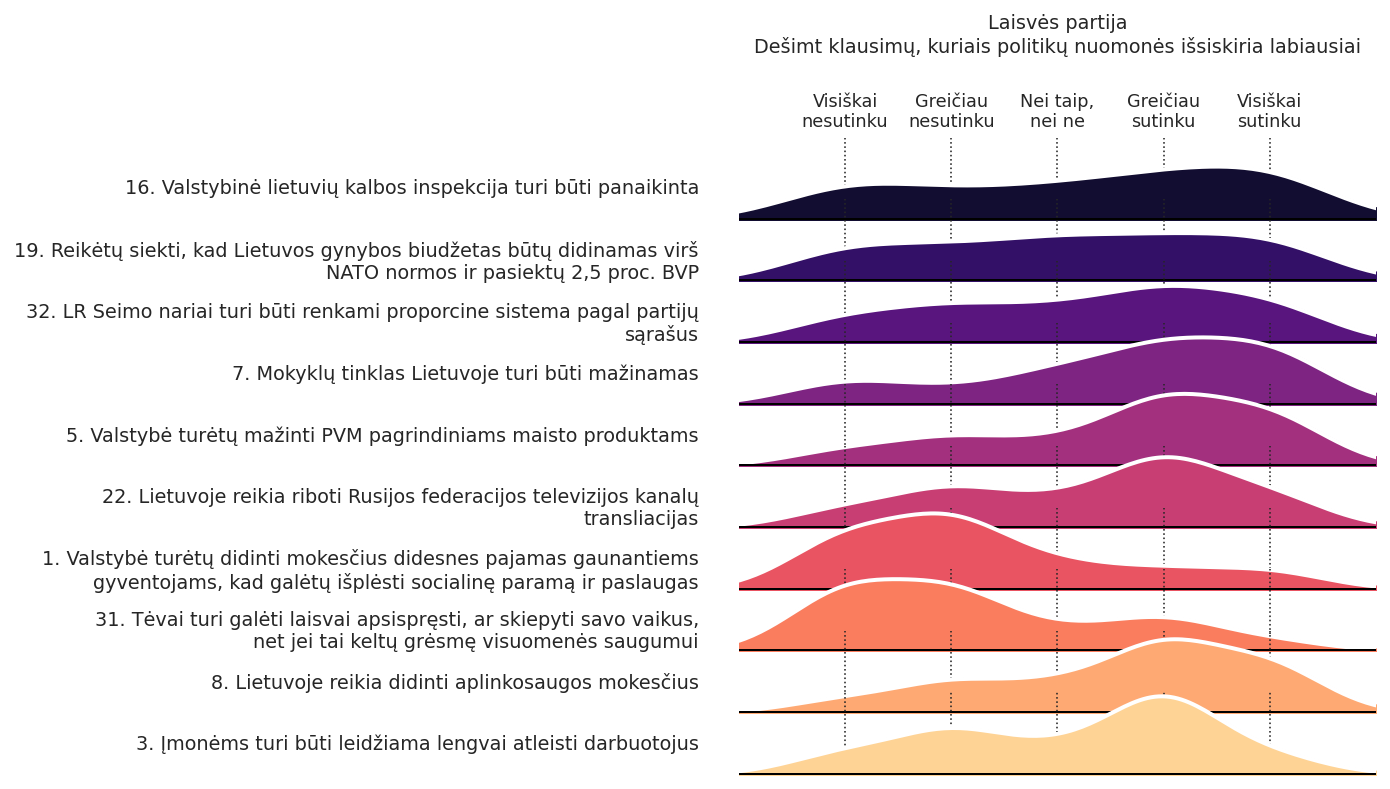

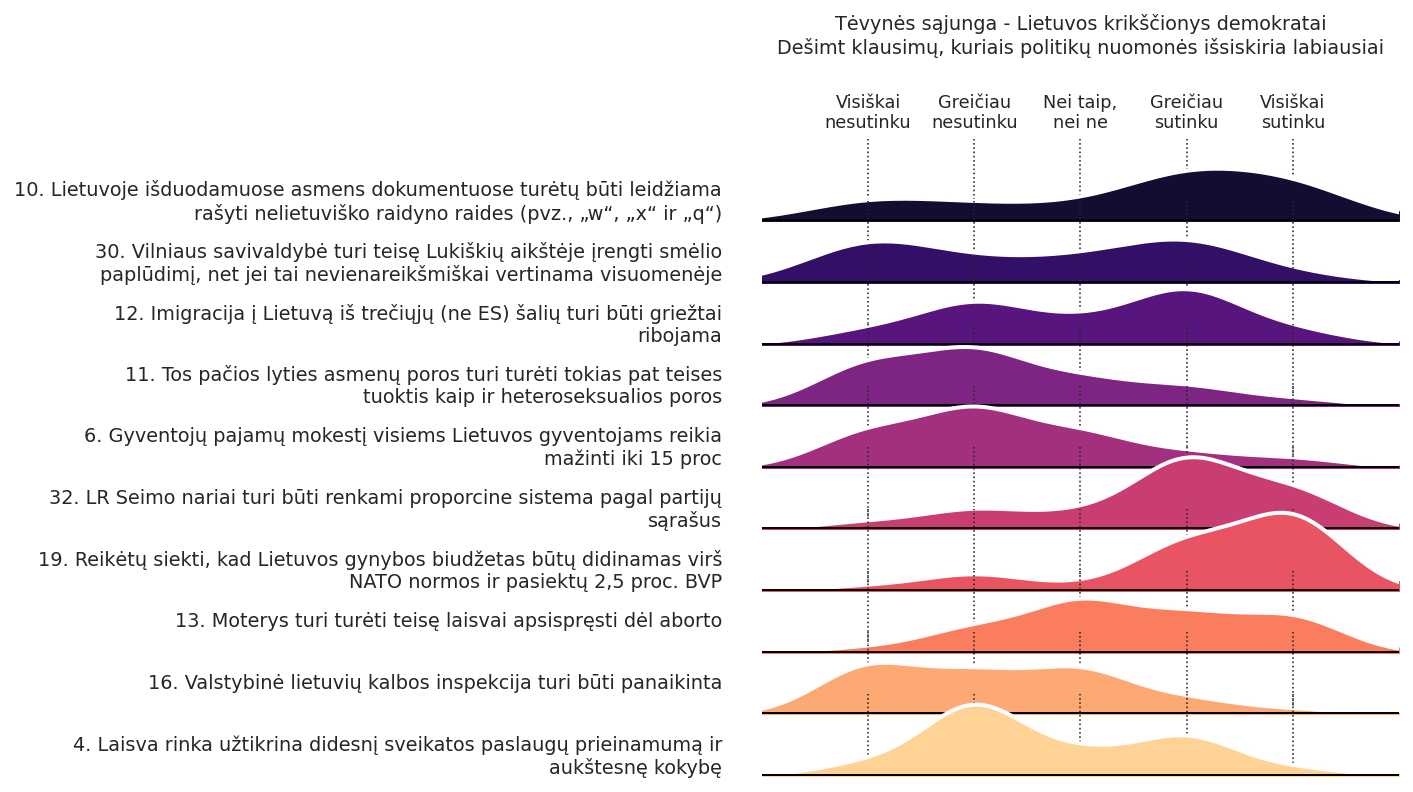

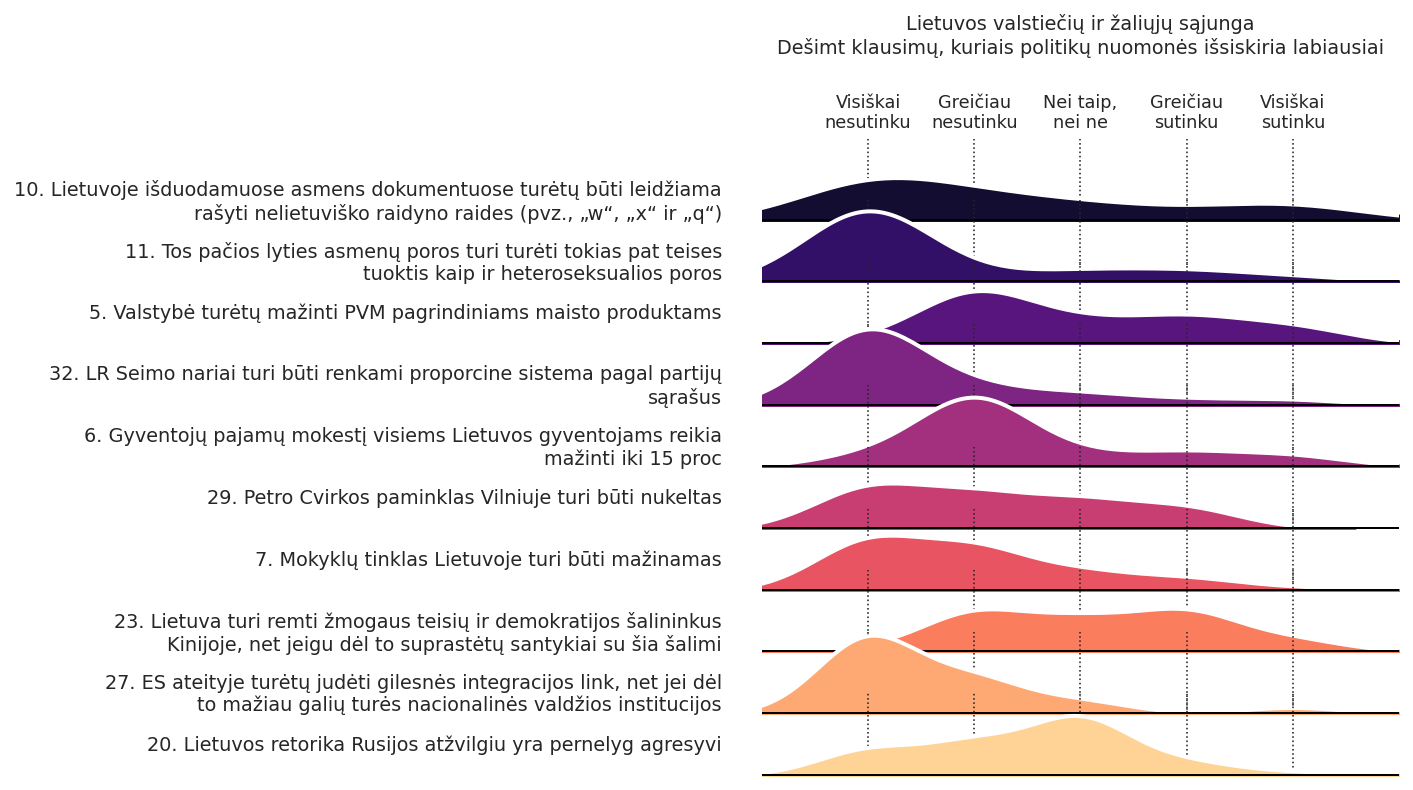

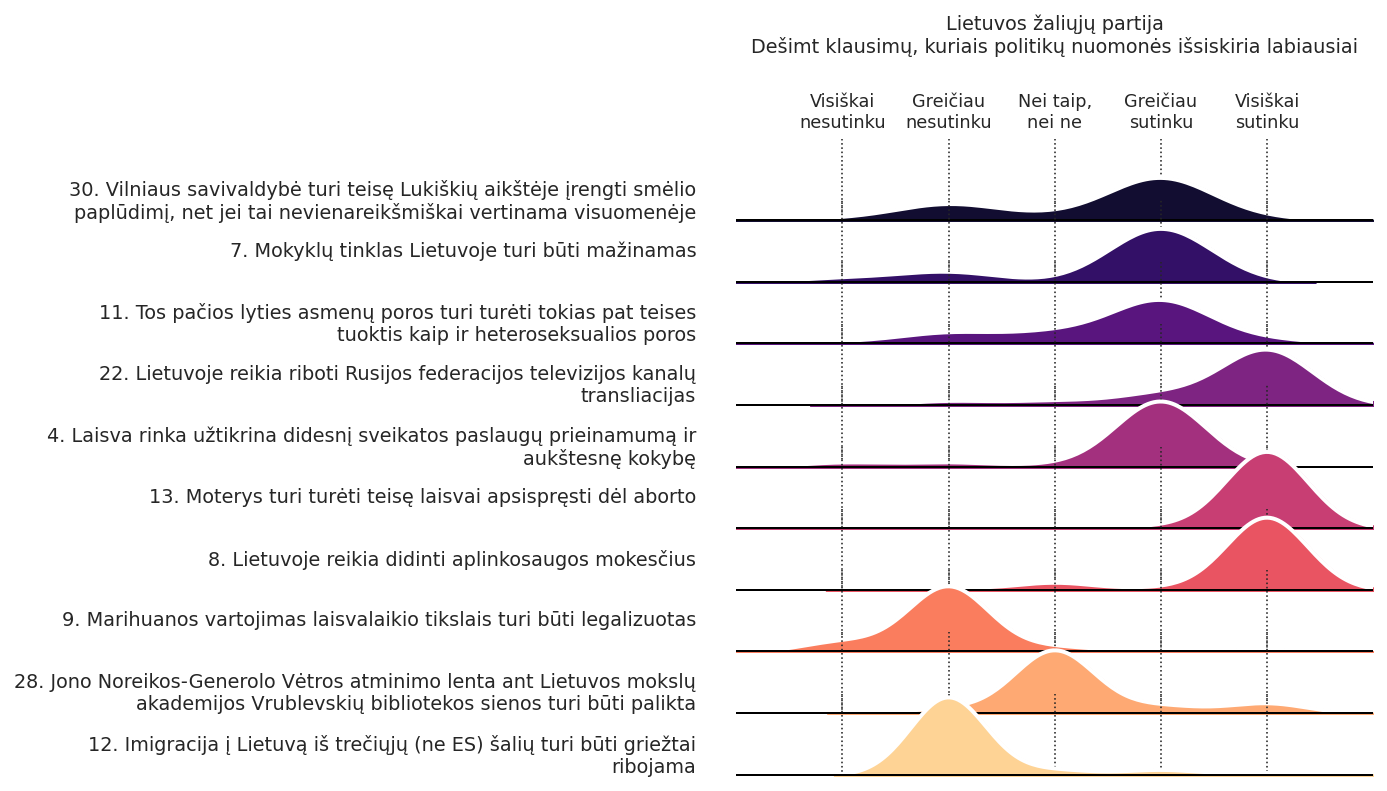

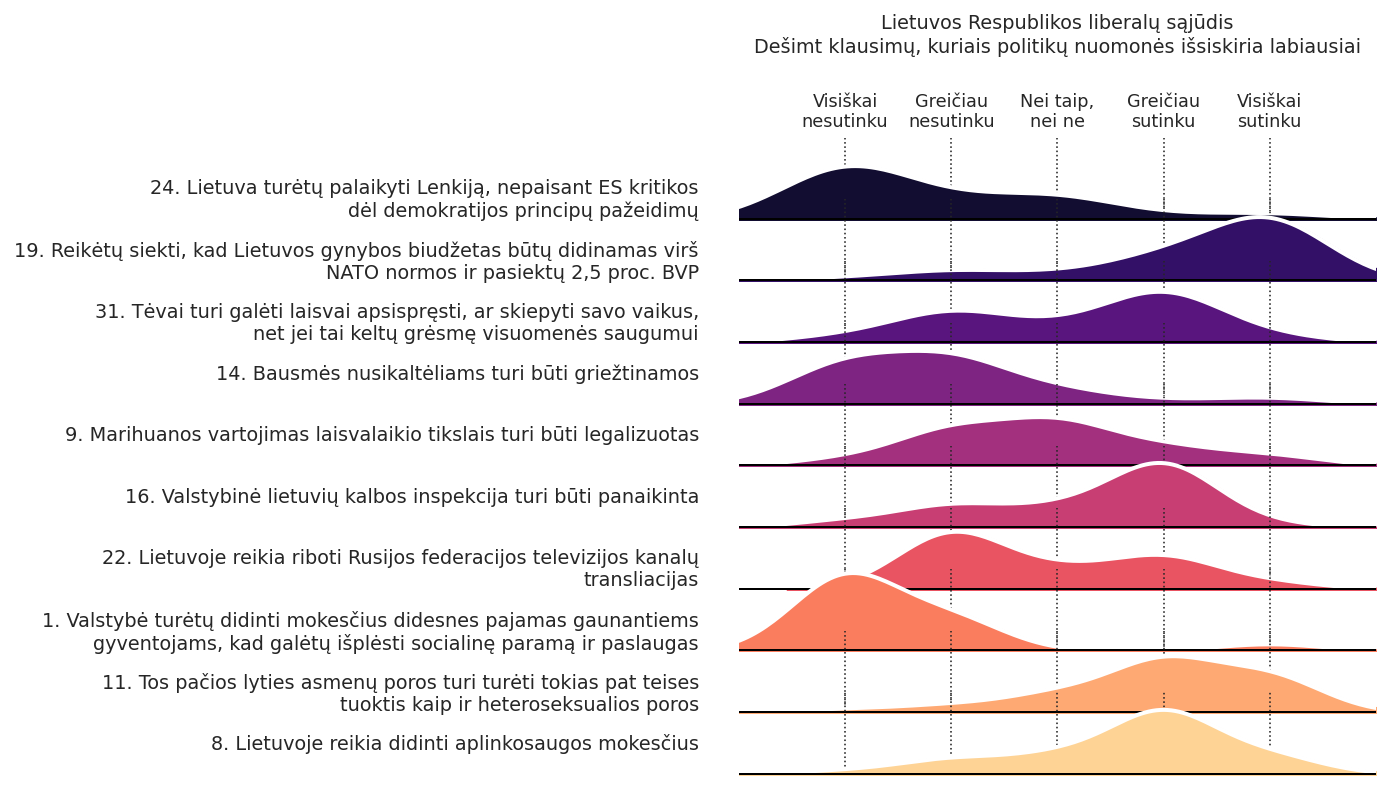

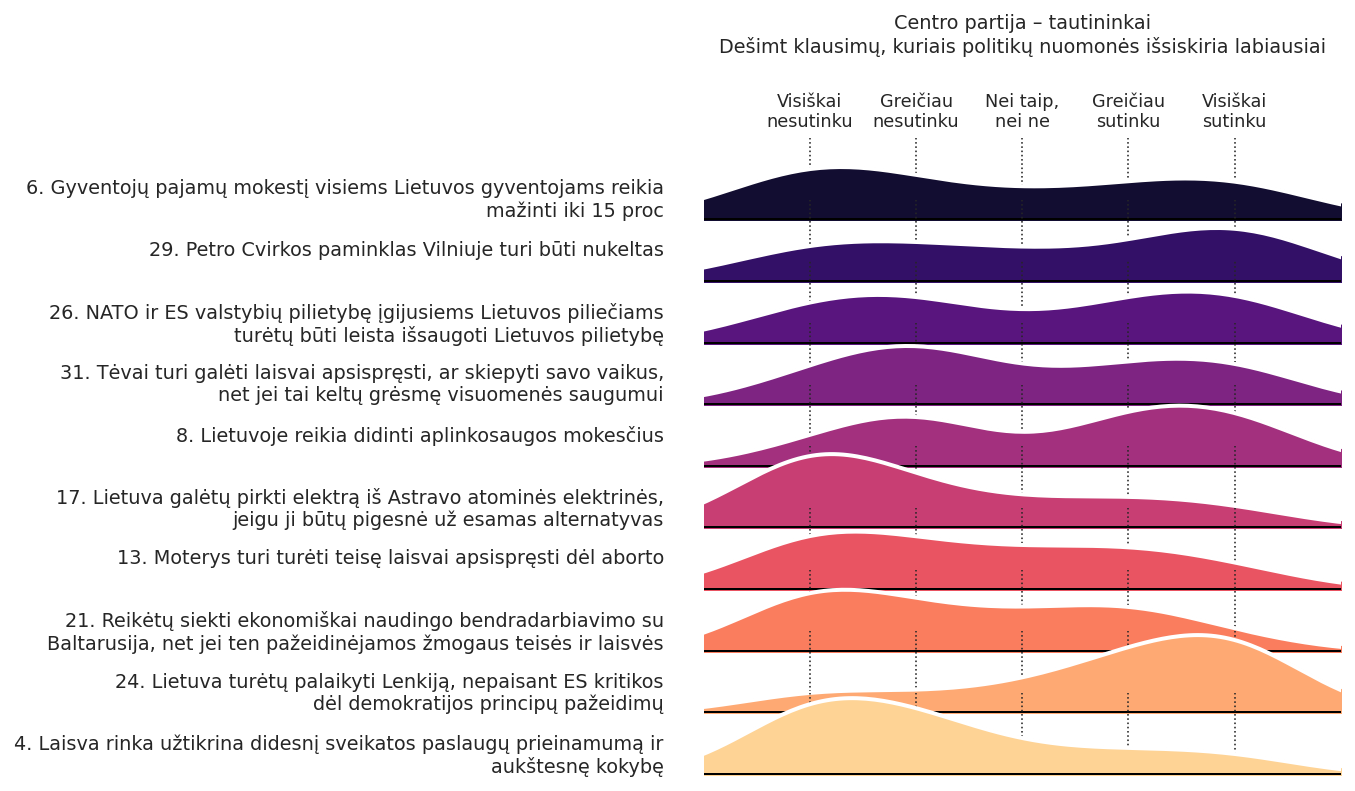

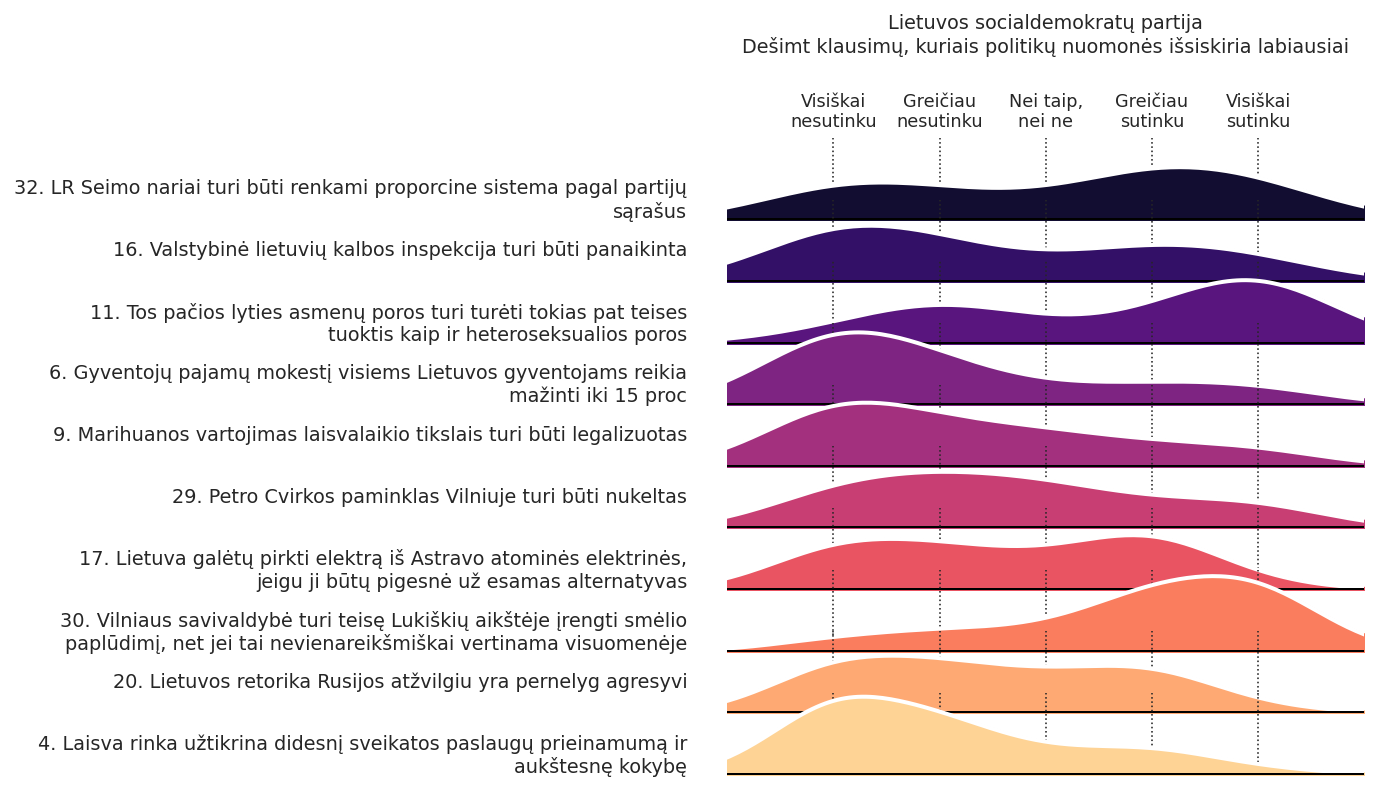

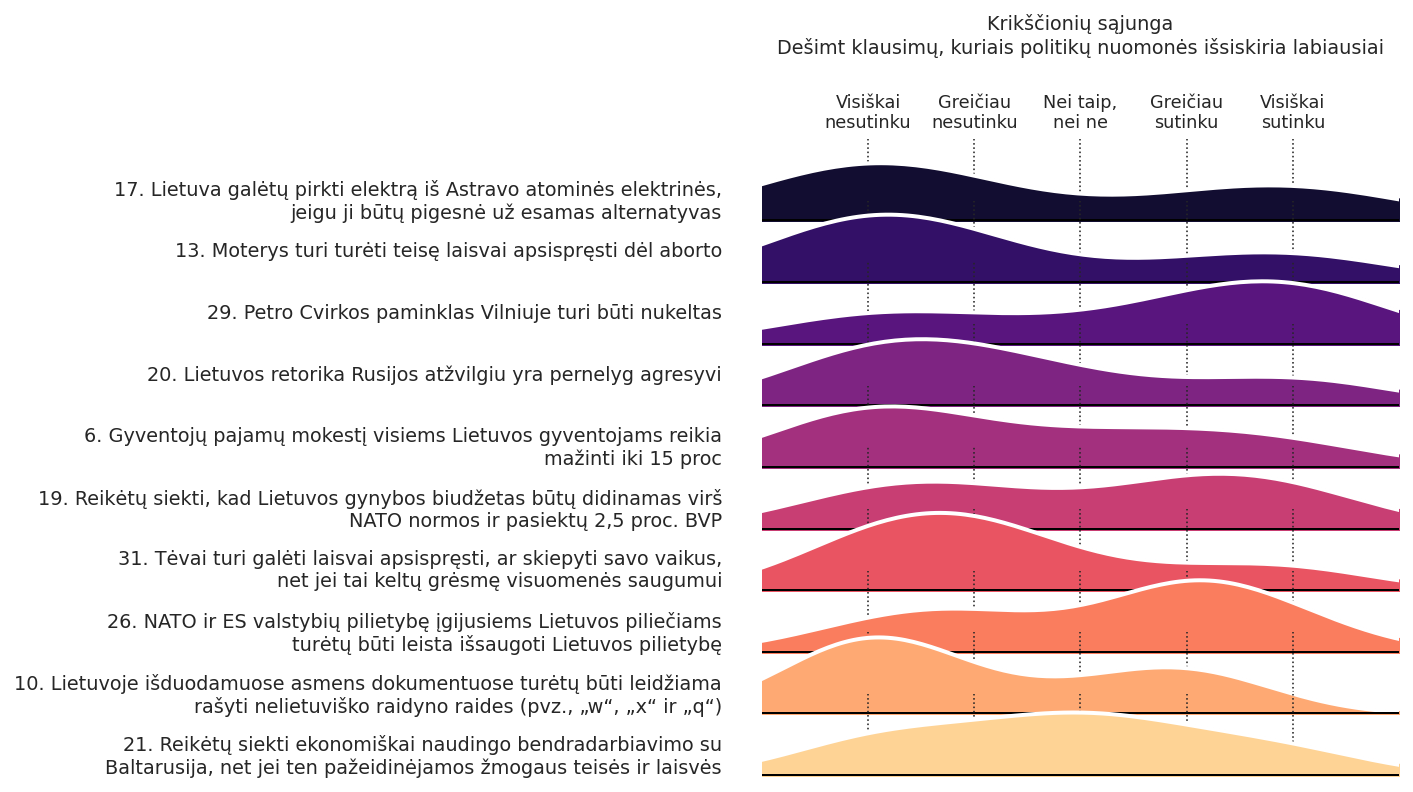

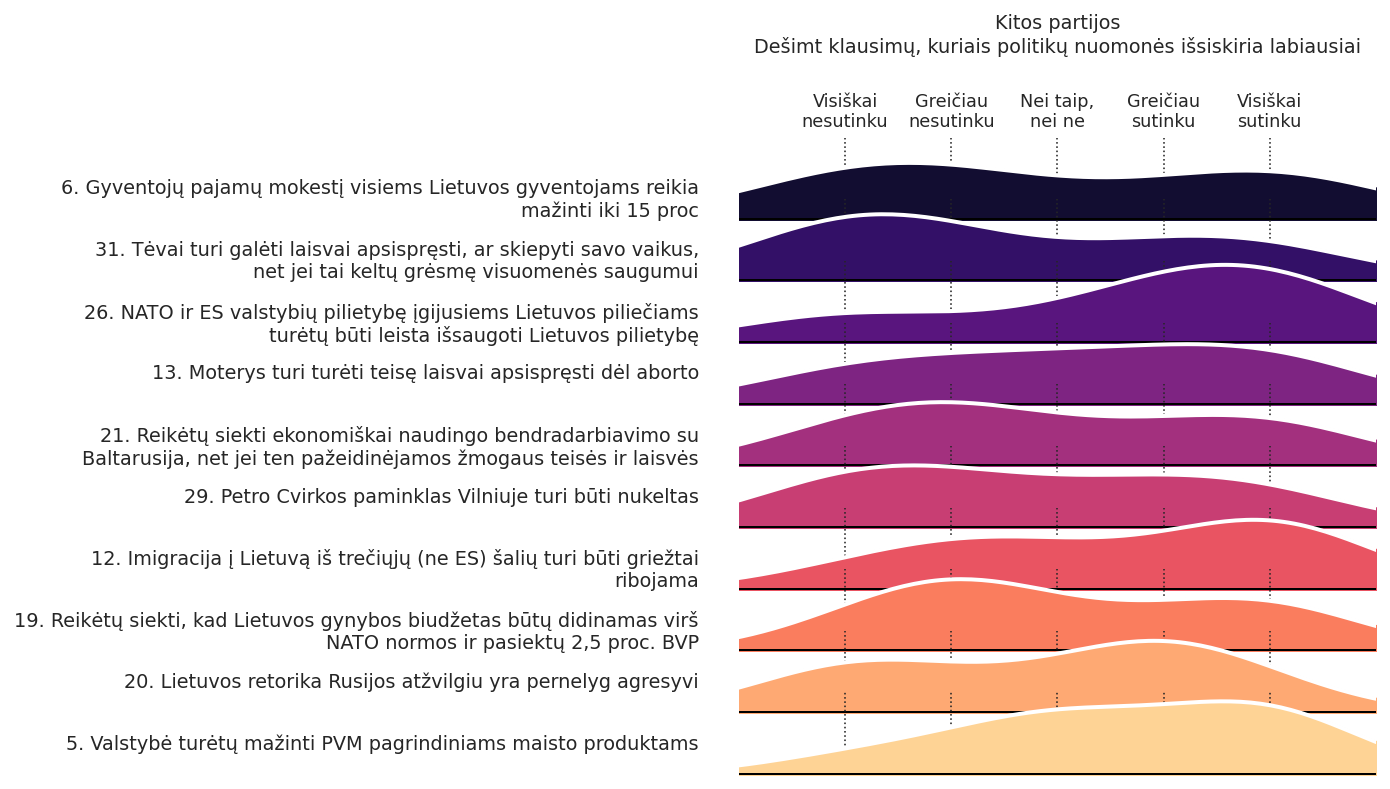

In [70]:
for party in parties:
    
    _df = data.loc[party].reset_index()
    party_variance_order = list(_df.groupby('question')['answer_code'].var().sort_values(ascending=False).index)
    
    x_order = party_variance_order[:10]

    fgrid = sns.FacetGrid(data=_df, row='question', 
                          hue='question',
                          palette='magma',
                          row_order=x_order, 
                          hue_order=x_order,
                          aspect=10, height=0.5, sharex=False)

    kde_kwargs = dict()
    fgrid.map(sns.kdeplot, "answer_code",
              clip_on=True,
              fill=True, alpha=1, linewidth=1.5, **kde_kwargs)

    fgrid.map(sns.kdeplot, "answer_code",
              clip_on=True,
              fill=False, 
              color="w", linewidth=2.0, 
              **kde_kwargs)


    fgrid.set_titles(row_template='{row_name}', col_template='')



    for i, ax in enumerate(fgrid.axes.ravel()):
        label = ax.get_title()
        ax.set_ylabel('\n'.join(textwrap.wrap(label, 70)), 
                      rotation='horizontal', ha='right', va='top', labelpad=20)
        ax.set_title('')
        ax.yaxis.grid(False)
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set_yticks([])

        ax.set_xlim([-3, 3])
        ax.set_xticks(ORDERED_ANSWER_CODES)

        ax.axhline(0, linestyle='-', color='black', linewidth=2)

        if i == 0:
            ax.xaxis.tick_top()
            ax.set_xticklabels(ORDERED_ANSWERS_FOR_LABELS)
            ax.set_title(f"{party}\nDešimt klausimų, kuriais politikų nuomonės išsiskiria labiausiai", pad=20)
        else:
            for tick in ax.get_xticklabels():
                tick.set_visible(False)

        ax.xaxis.set_tick_params(length=0)
        ax.set_xlabel('')
        ax.patch.set_alpha(0)

    fgrid.fig.subplots_adjust(hspace=-0.25)
    
    party_friendly_name = party.replace(' ', '-')
    fgrid.savefig(os.path.join(OUTDIR, f'klausimai-pagal-nesutarima-{party_friendly_name}.pdf'))
    
#     break

In [69]:
party_friendly_name

'Laisvės-partija'

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


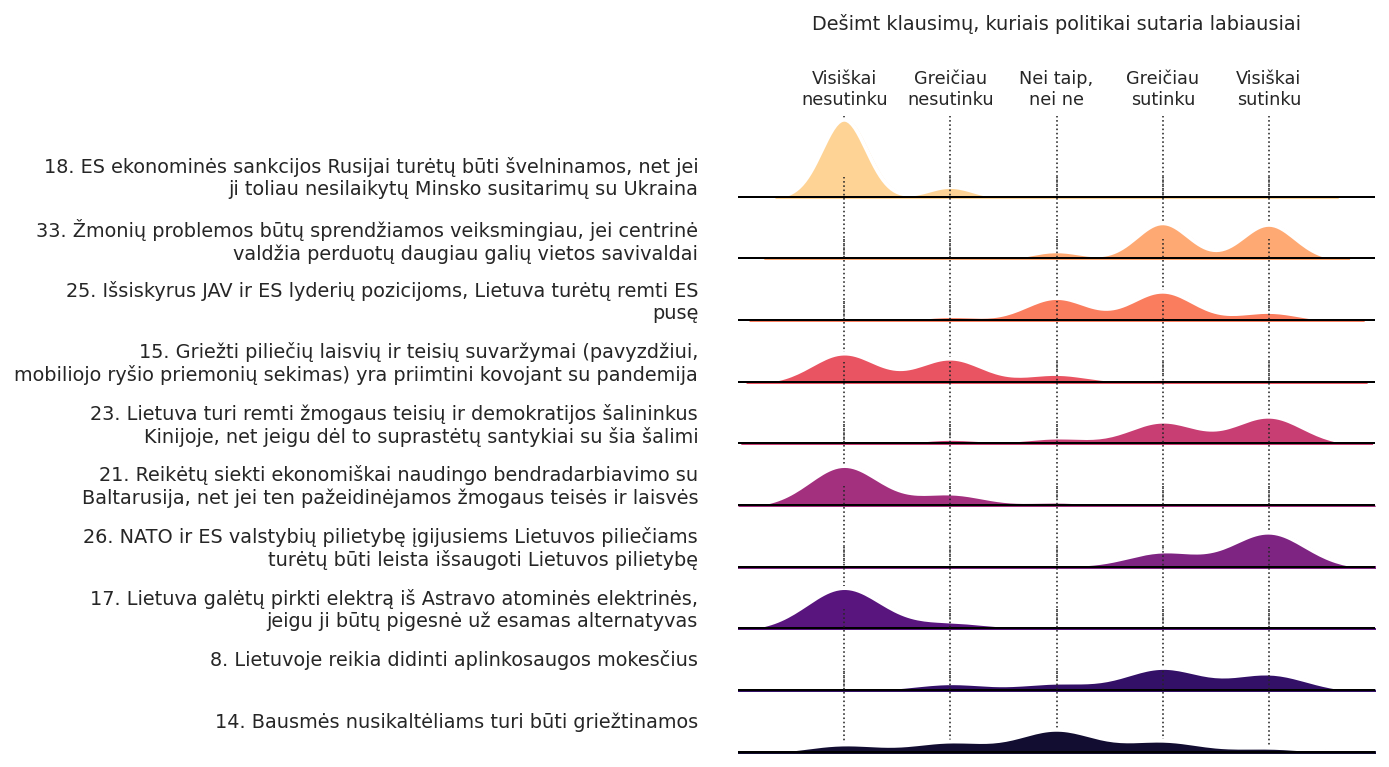

In [13]:
_df = data.reset_index()

x_order = variance_order[-10:]
x_order = list(reversed(x_order))

fgrid = sns.FacetGrid(data=_df, row='question', 
                      hue='question',
                      palette='magma',
                      row_order=x_order, 
                      hue_order=list(reversed(x_order)),
                      aspect=10, height=0.5, sharex=False)

kde_kwargs = dict()
fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=True, alpha=1, linewidth=1.5, **kde_kwargs)

fgrid.map(sns.kdeplot, "answer_code",
          clip_on=True,
          fill=False, 
          color="w", linewidth=2.0, 
          **kde_kwargs)


fgrid.set_titles(row_template='{row_name}', col_template='')



for i, ax in enumerate(fgrid.axes.ravel()):
    label = ax.get_title()
    ax.set_ylabel('\n'.join(textwrap.wrap(label, 70)), 
                  rotation='horizontal', ha='right', va='top', labelpad=20)
    ax.set_title('')
    ax.yaxis.grid(False)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    
    ax.set_xlim([-3, 3])
    ax.set_xticks(ORDERED_ANSWER_CODES)
    
    ax.axhline(0, linestyle='-', color='black', linewidth=2)
    
    if i == 0:
        ax.xaxis.tick_top()
        ax.set_xticklabels(ORDERED_ANSWERS_FOR_LABELS)
        ax.set_title("Dešimt klausimų, kuriais politikai sutaria labiausiai", pad=20)
    else:
        for tick in ax.get_xticklabels():
            tick.set_visible(False)
            
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlabel('')
    ax.patch.set_alpha(0)
    
fgrid.fig.subplots_adjust(hspace=-0.25)
fgrid.savefig(os.path.join(OUTDIR, 'klausimai-pagal-sutarima-top10.pdf'))

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of t

/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/saulius.lukauskas/.virtualenvs/py38-rinkimai-2020/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of t

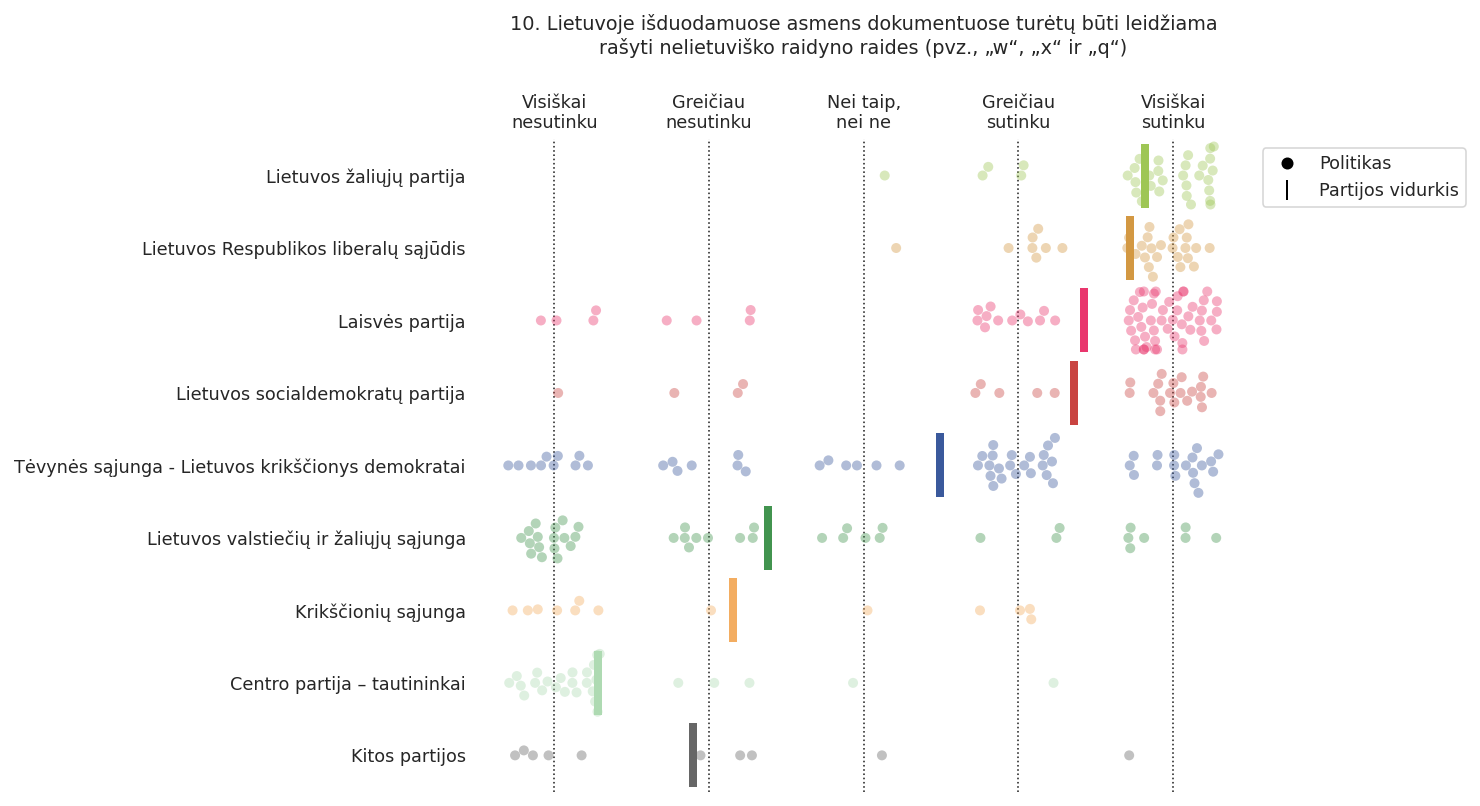

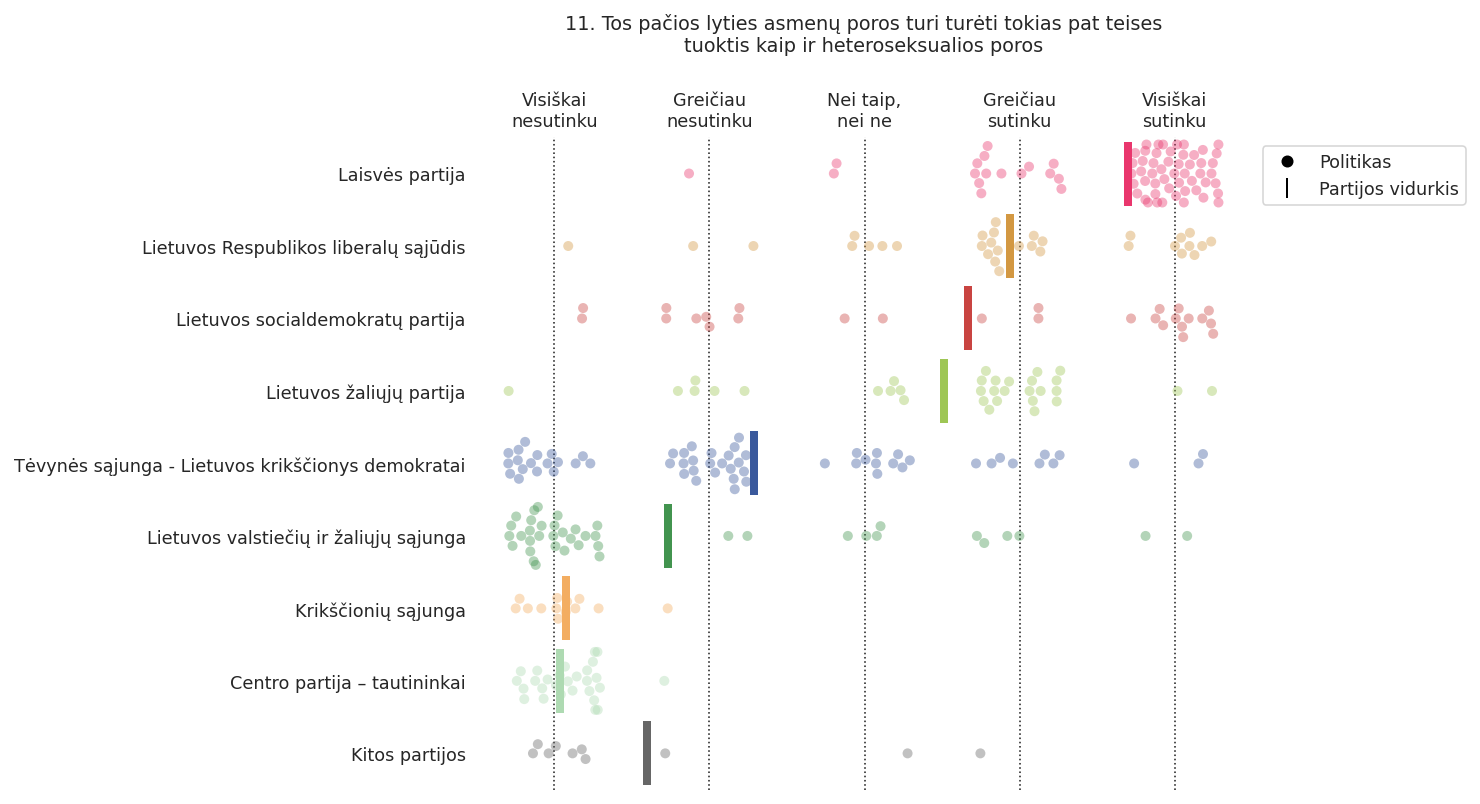

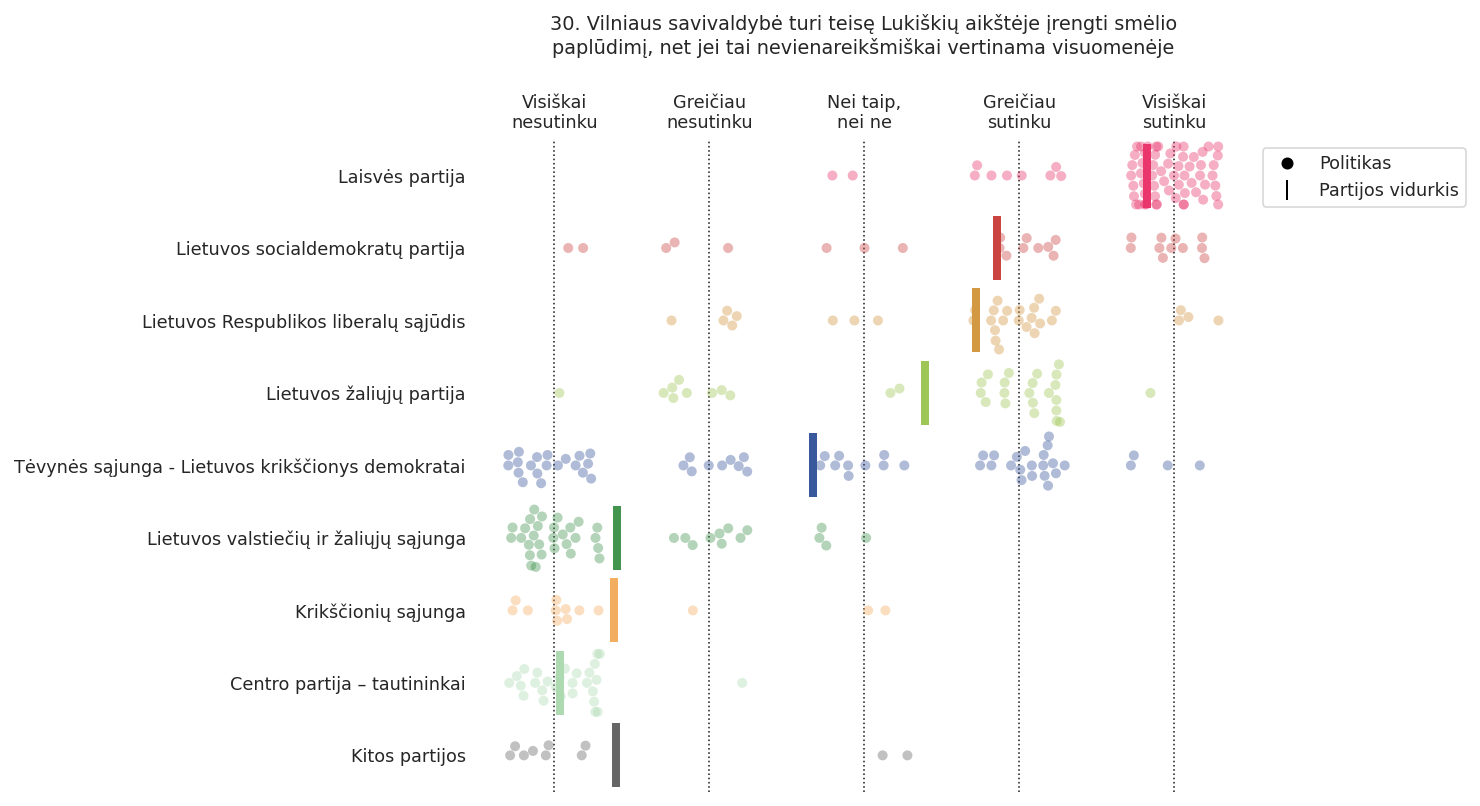

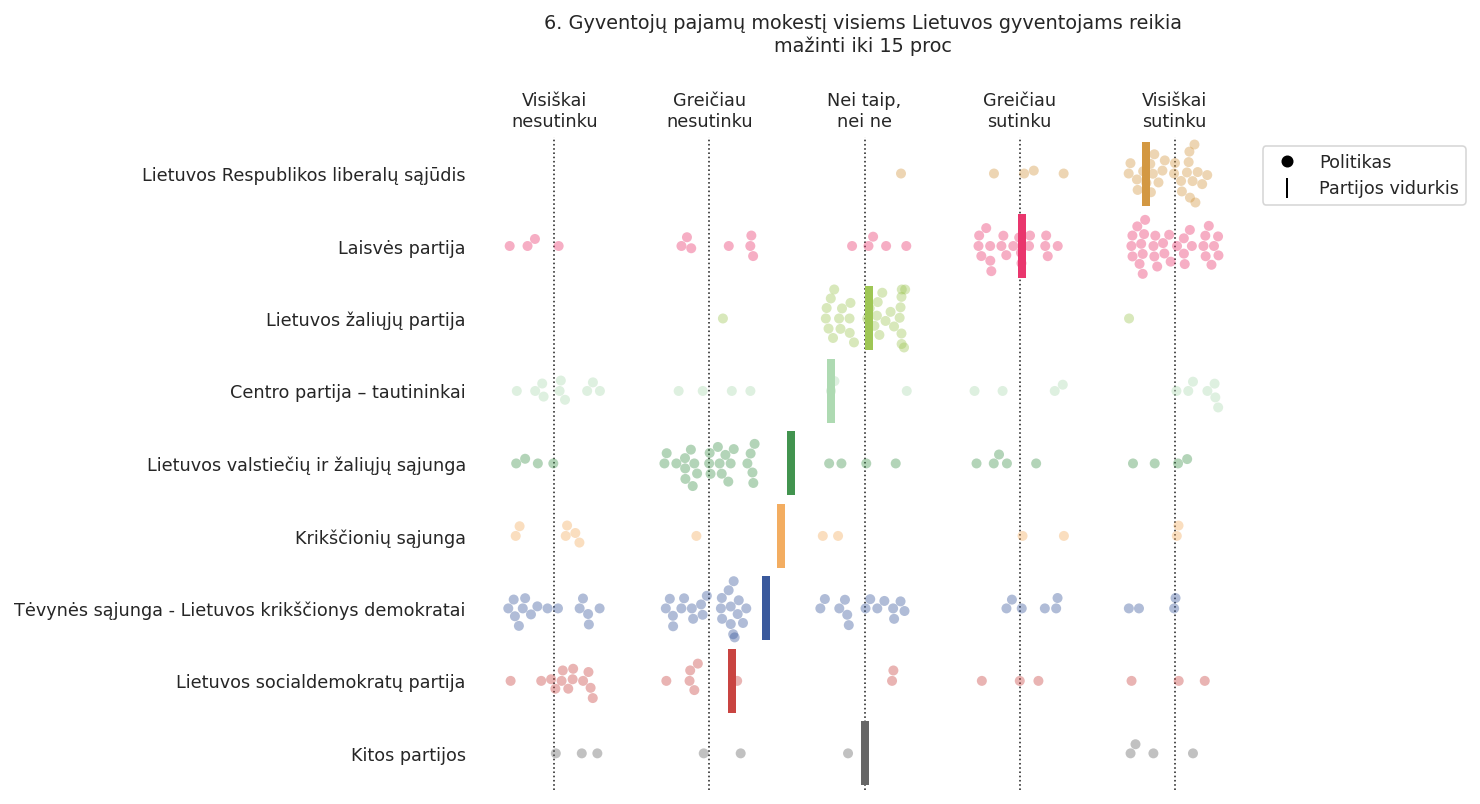

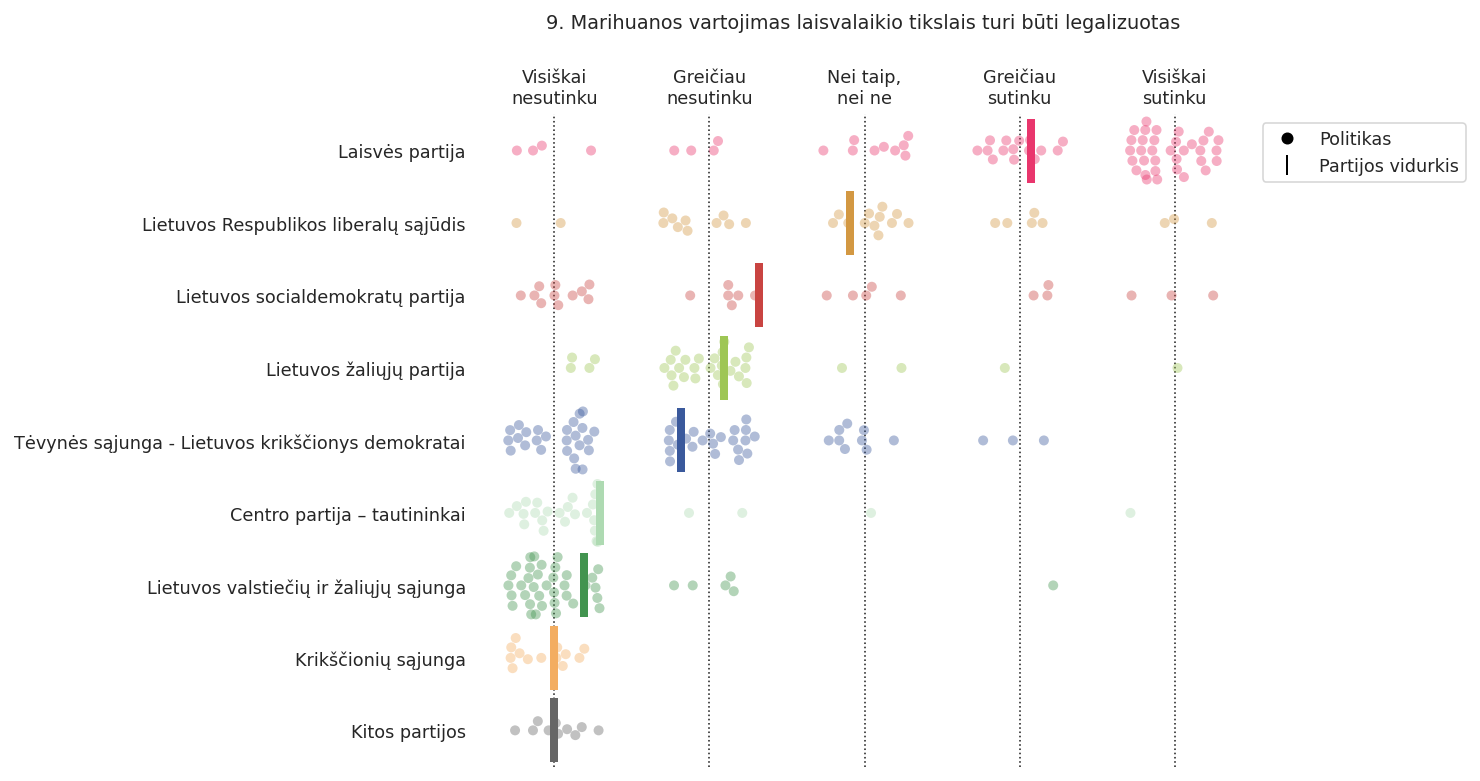

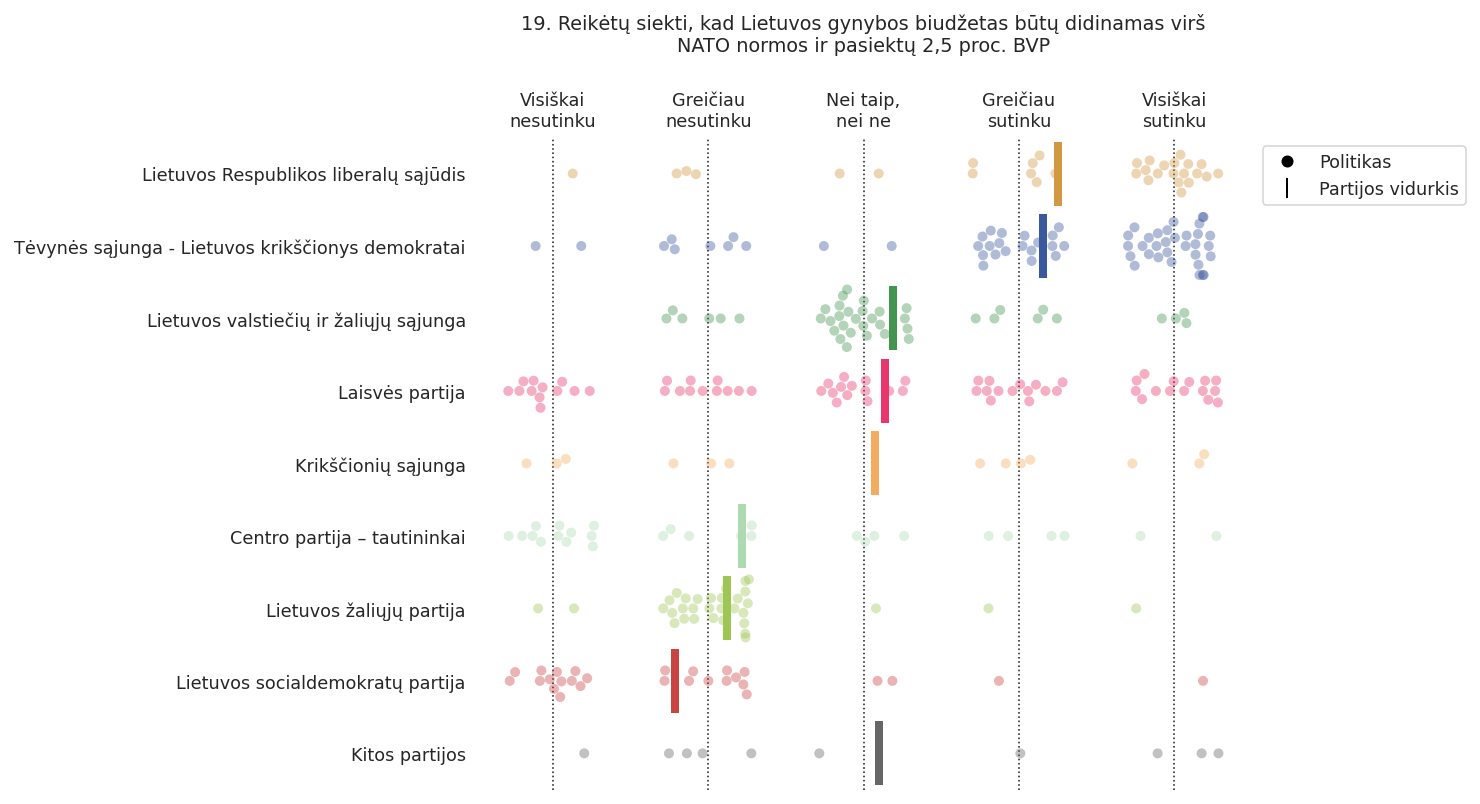

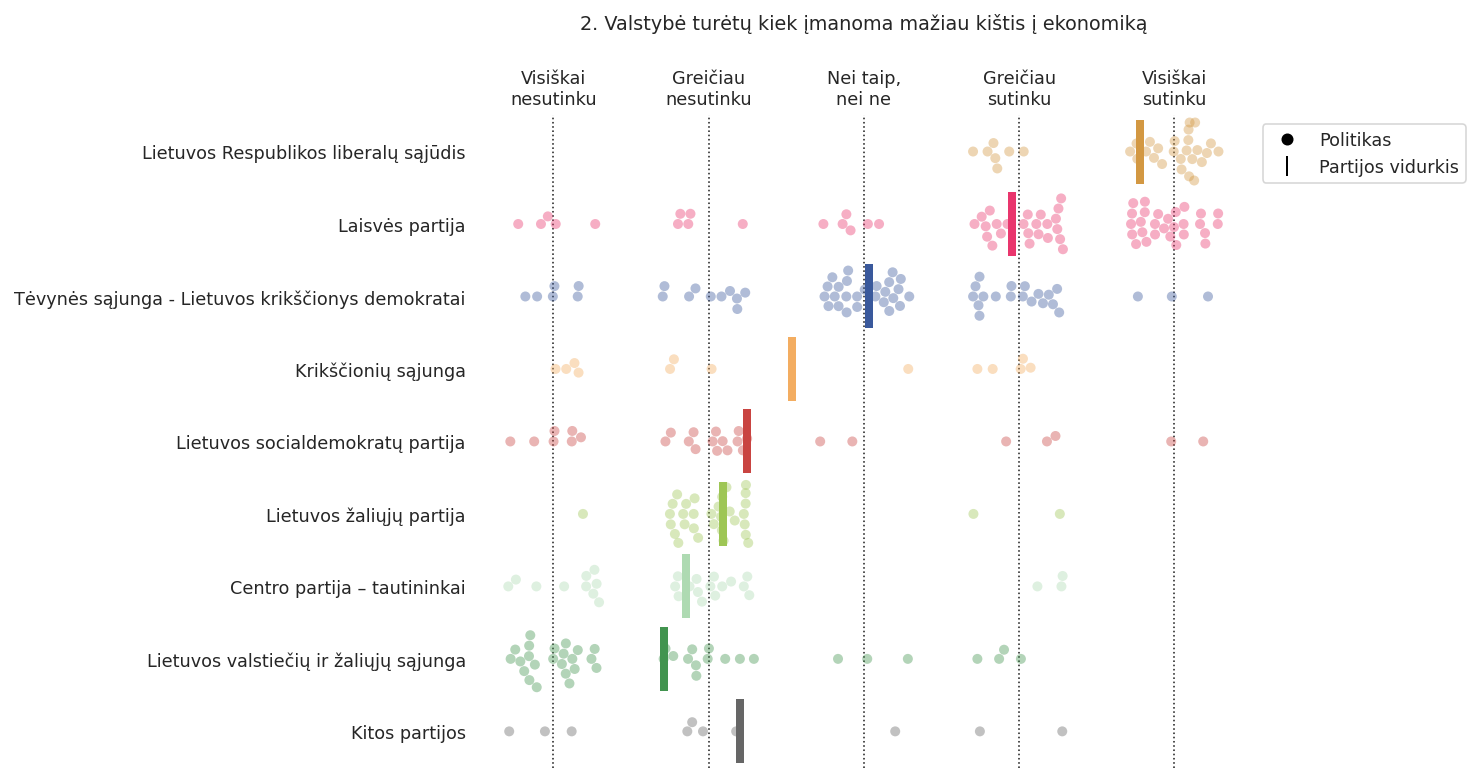

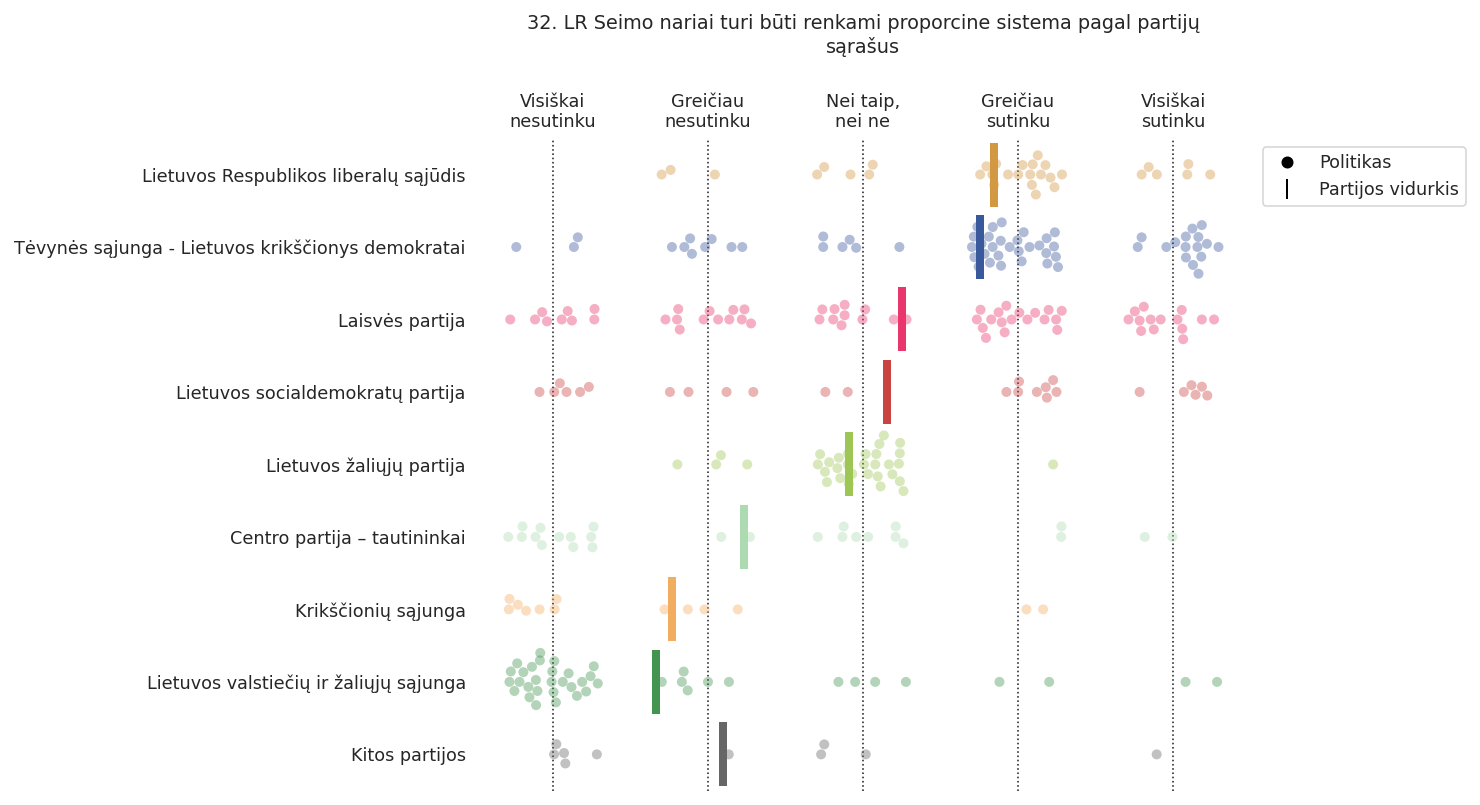

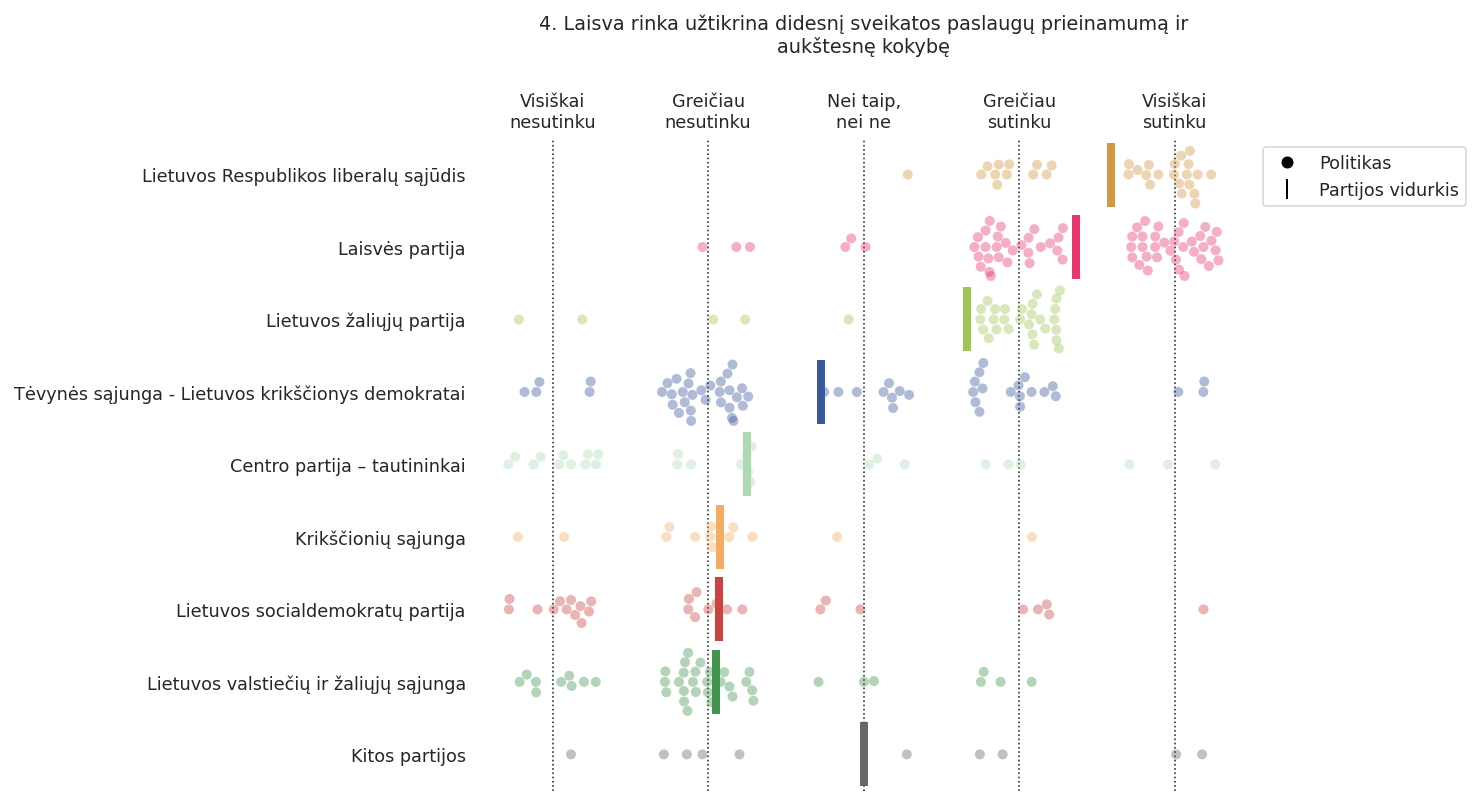

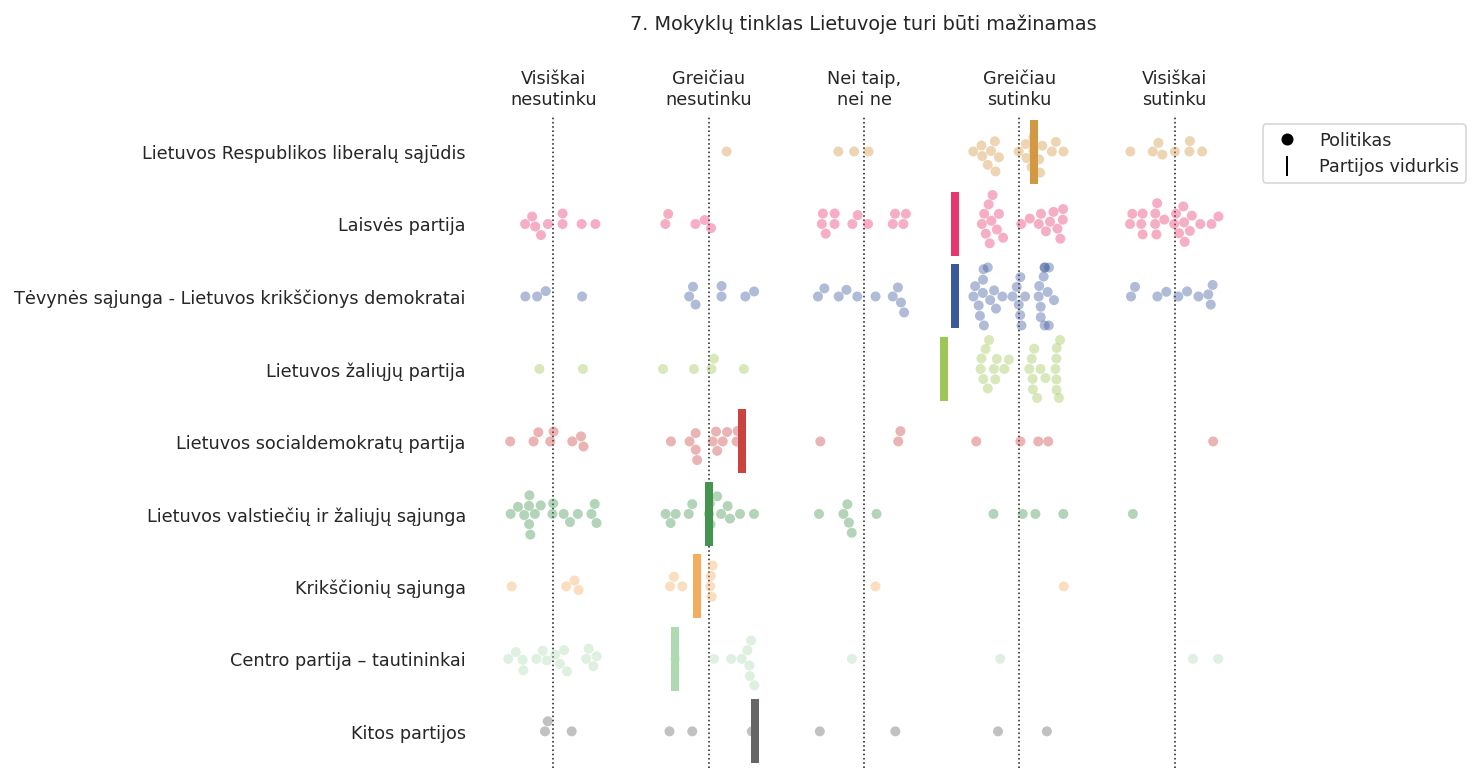

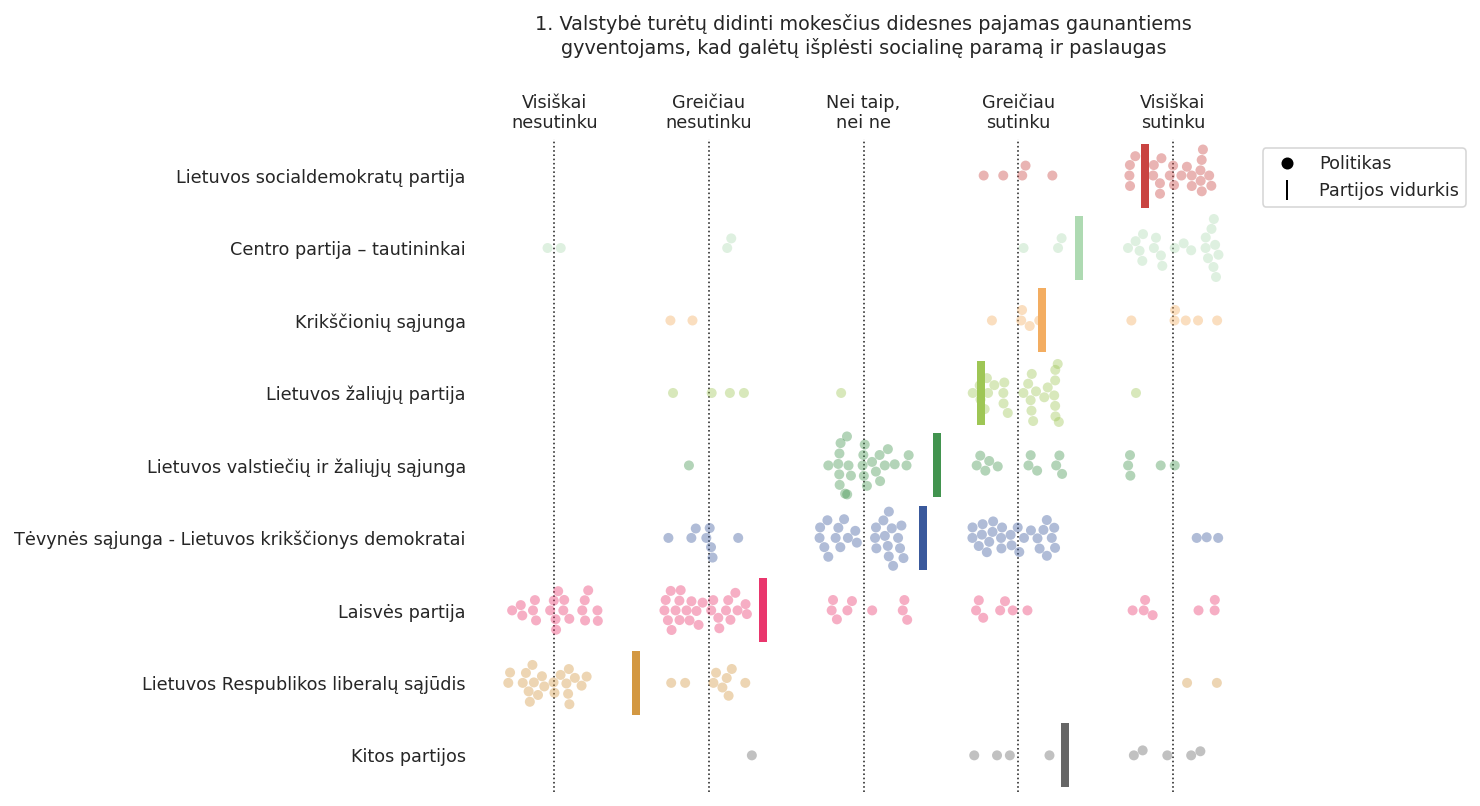

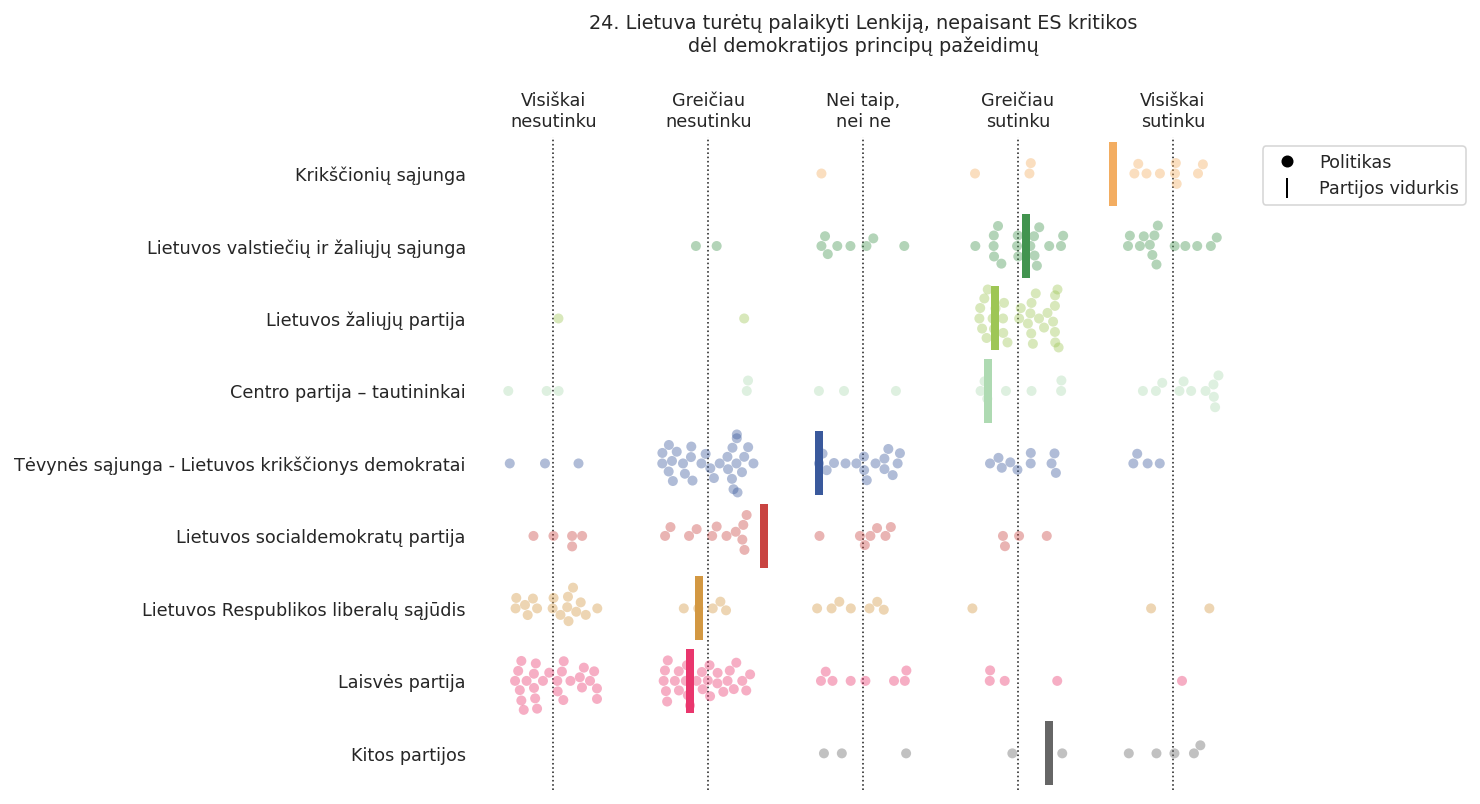

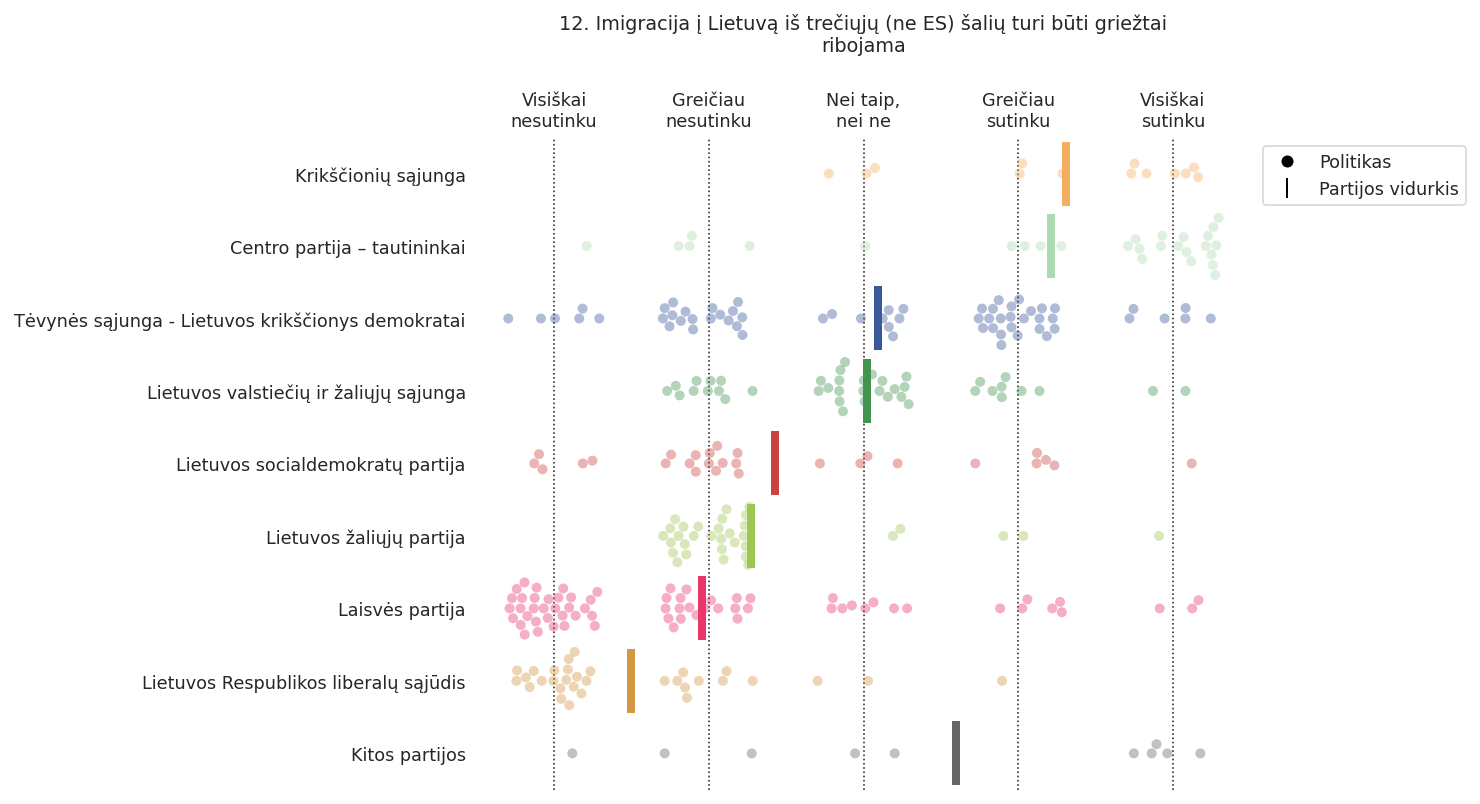

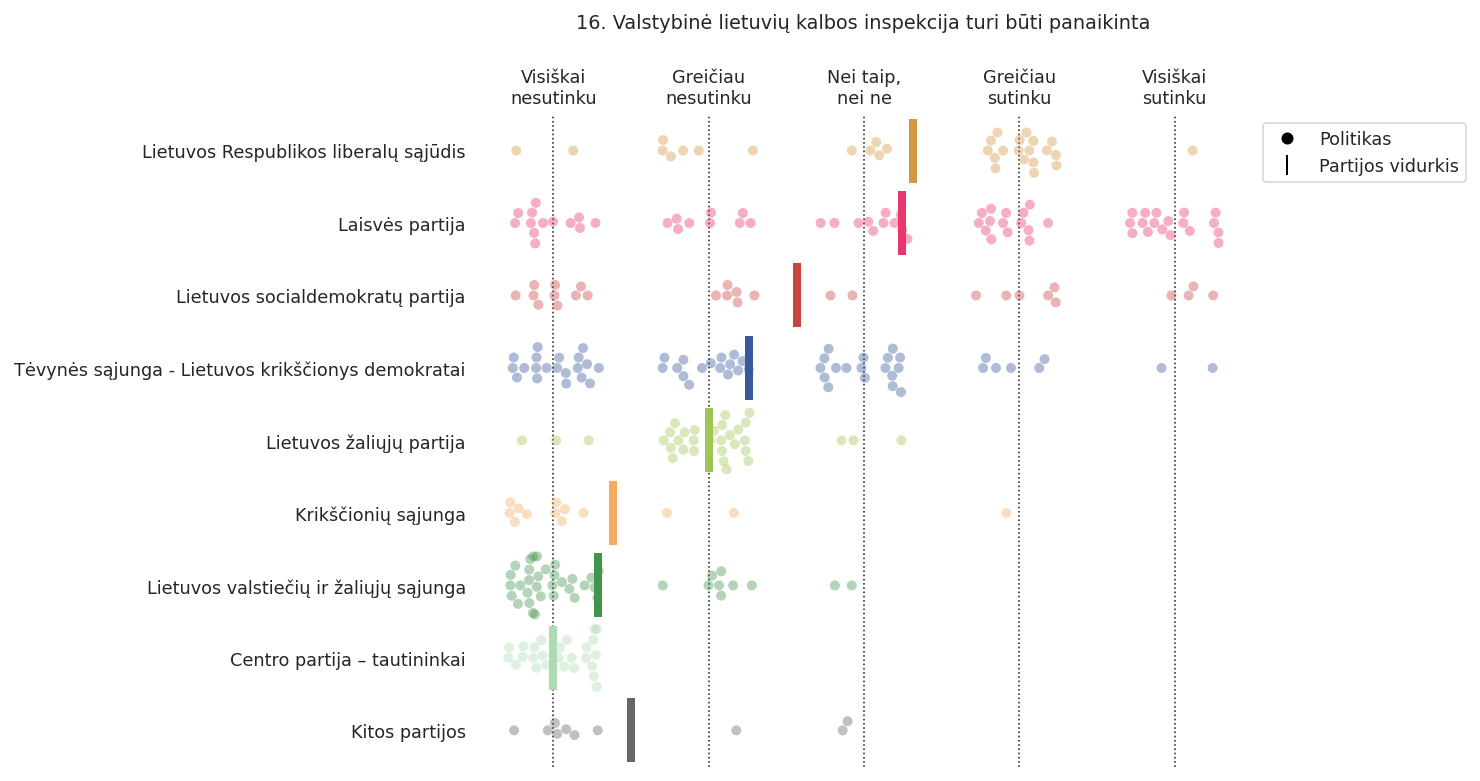

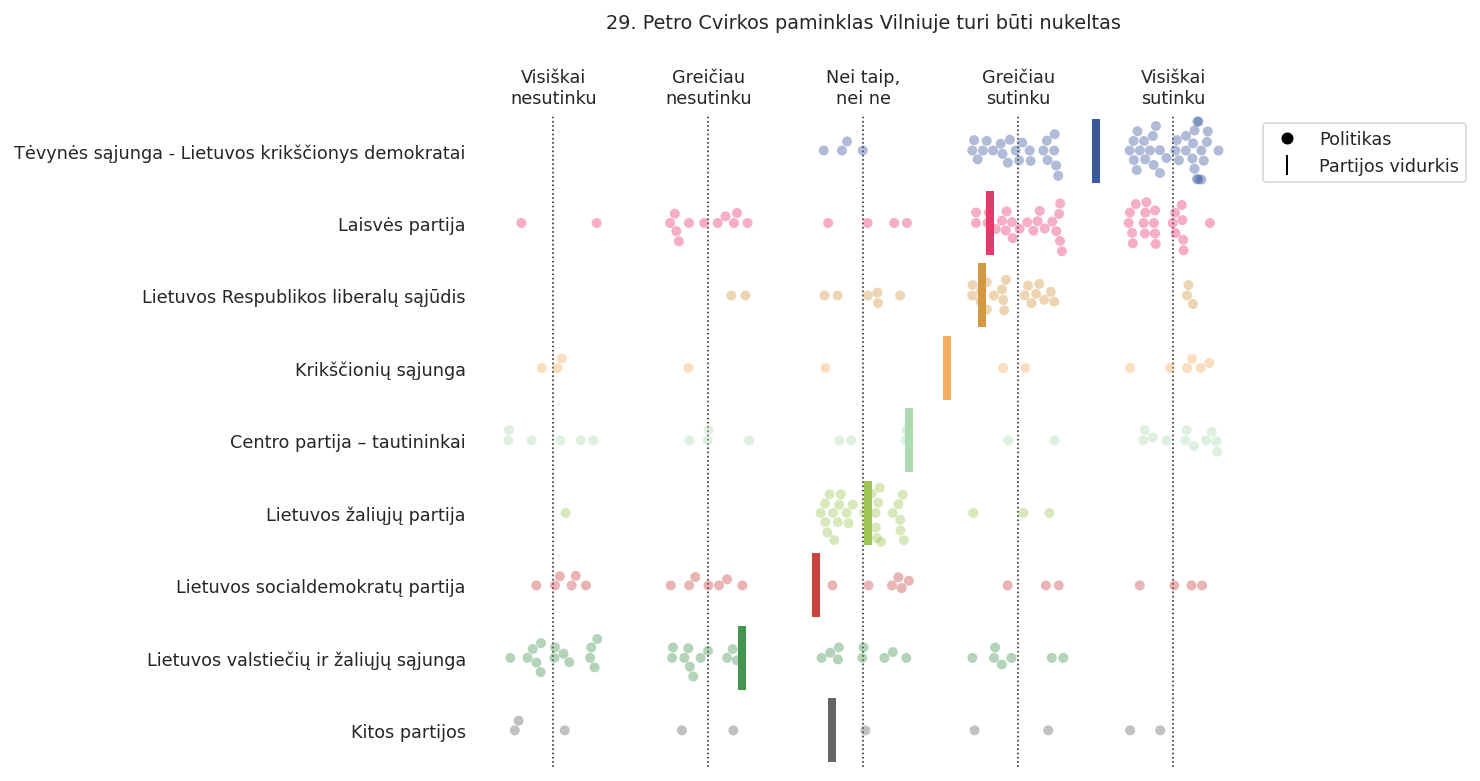

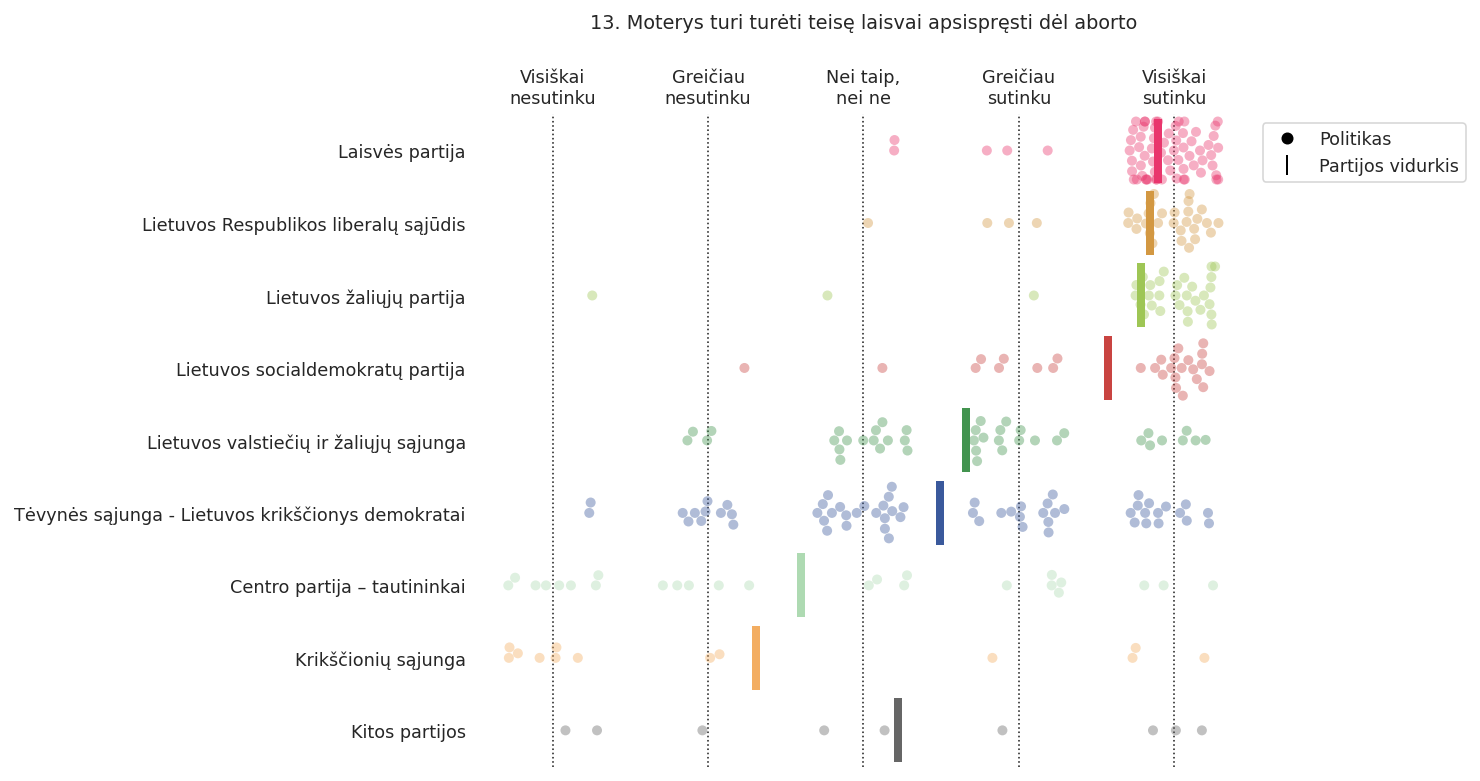

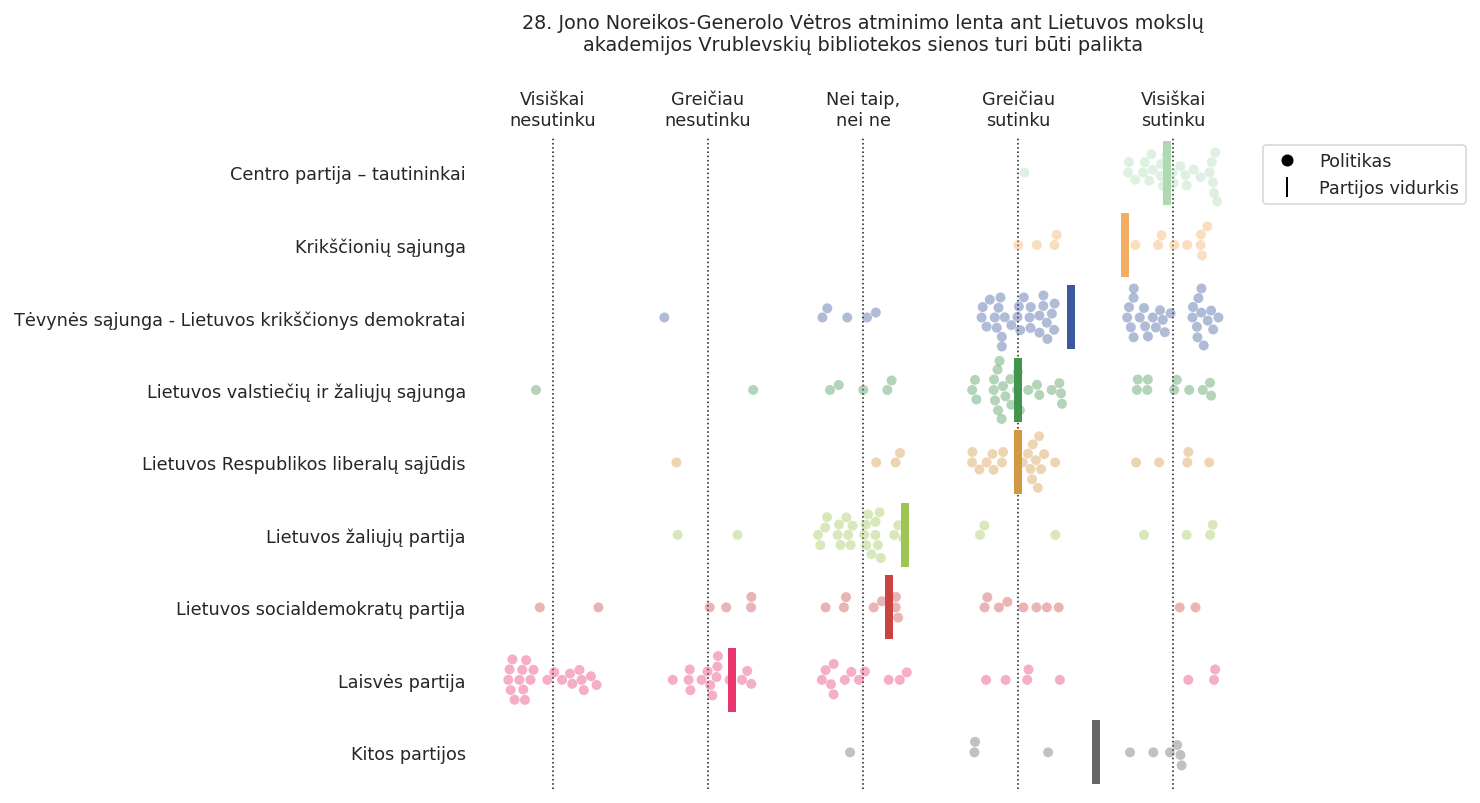

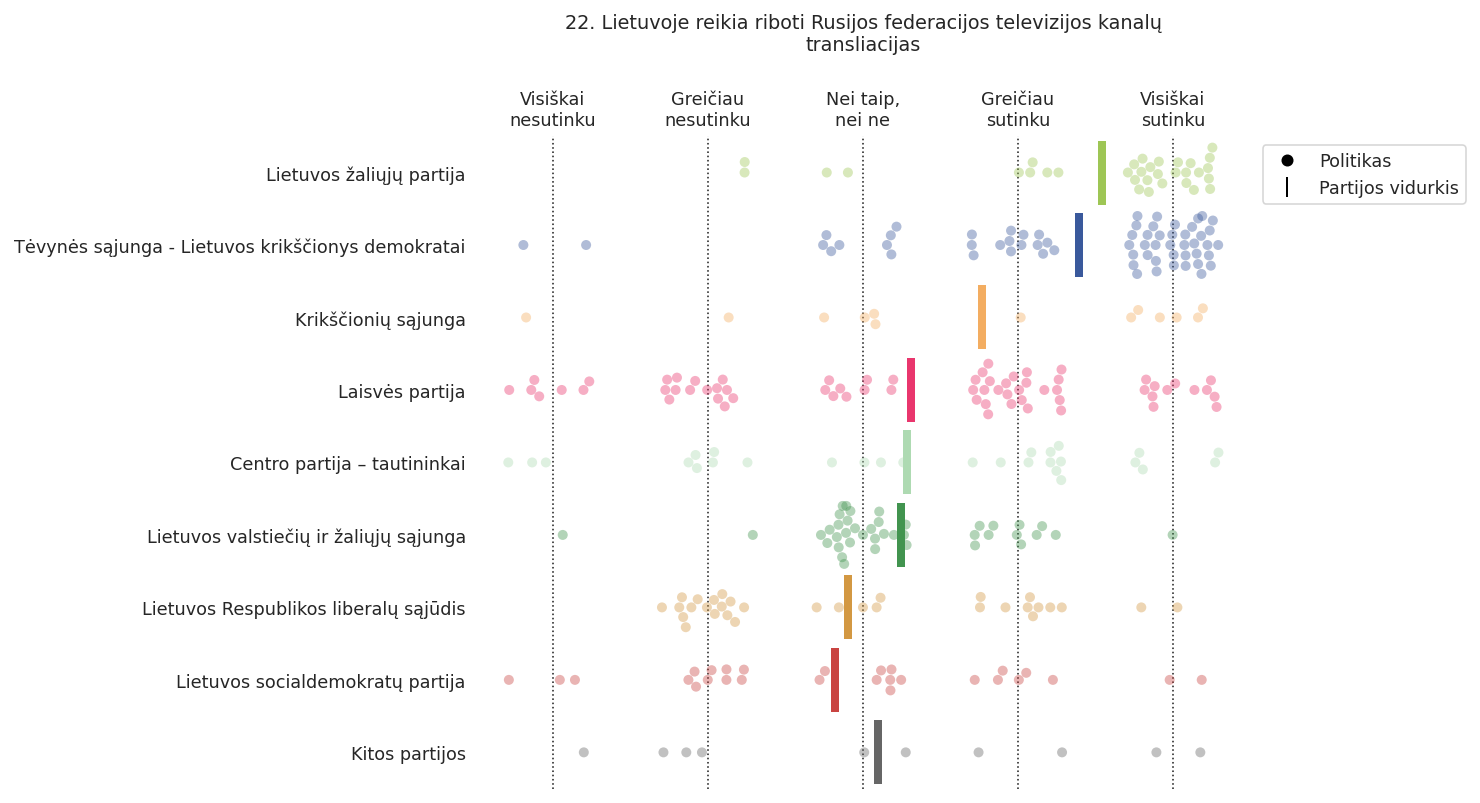

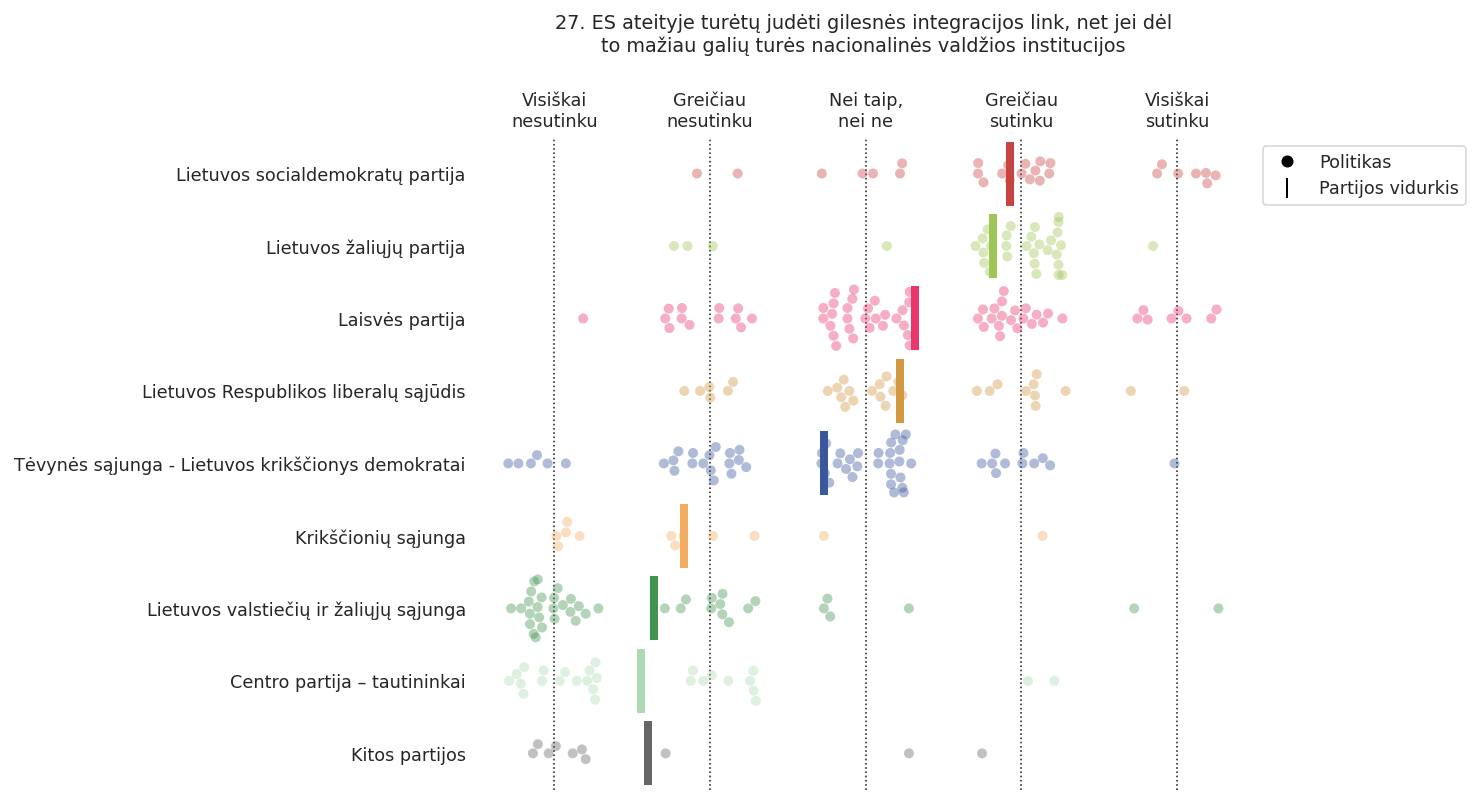

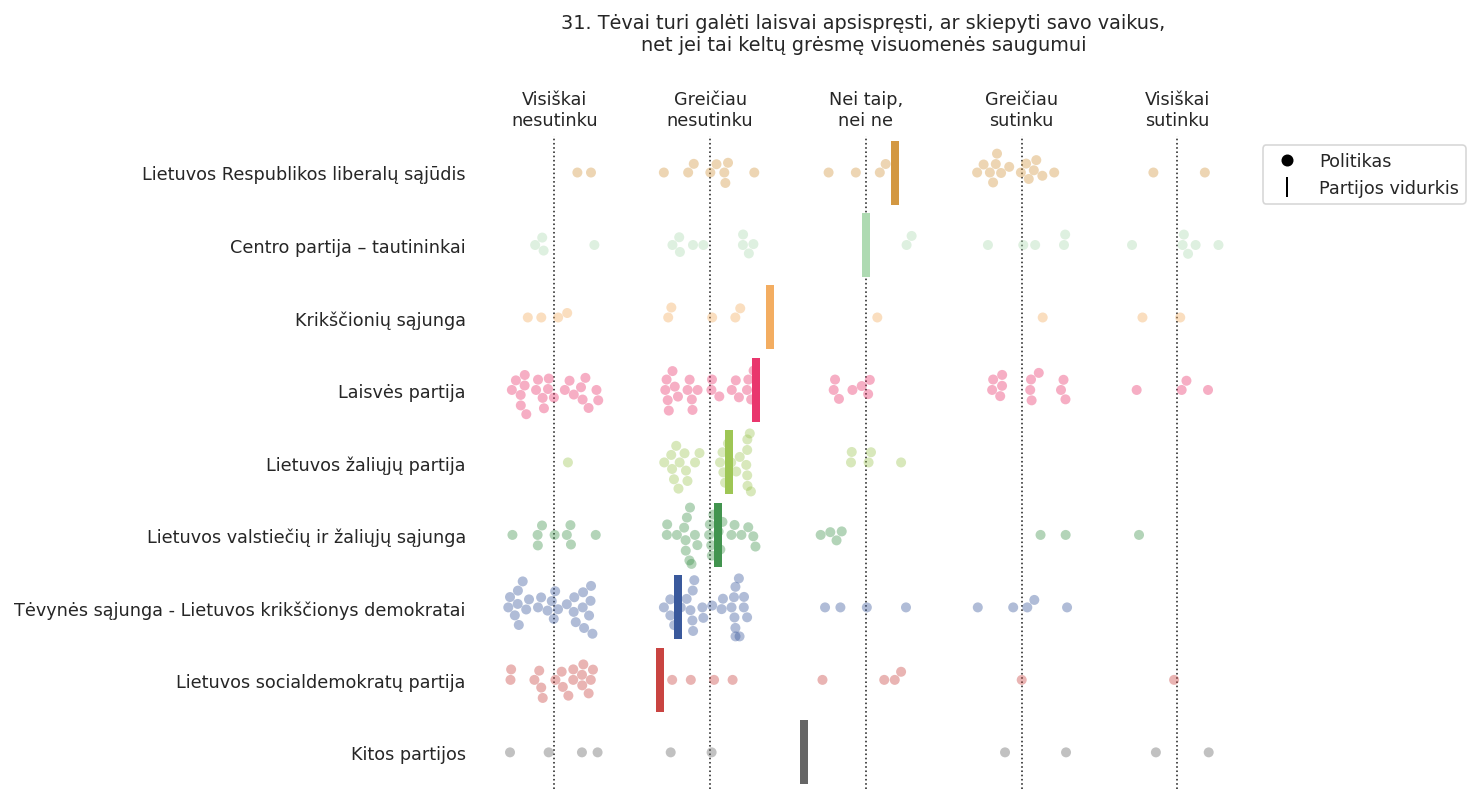

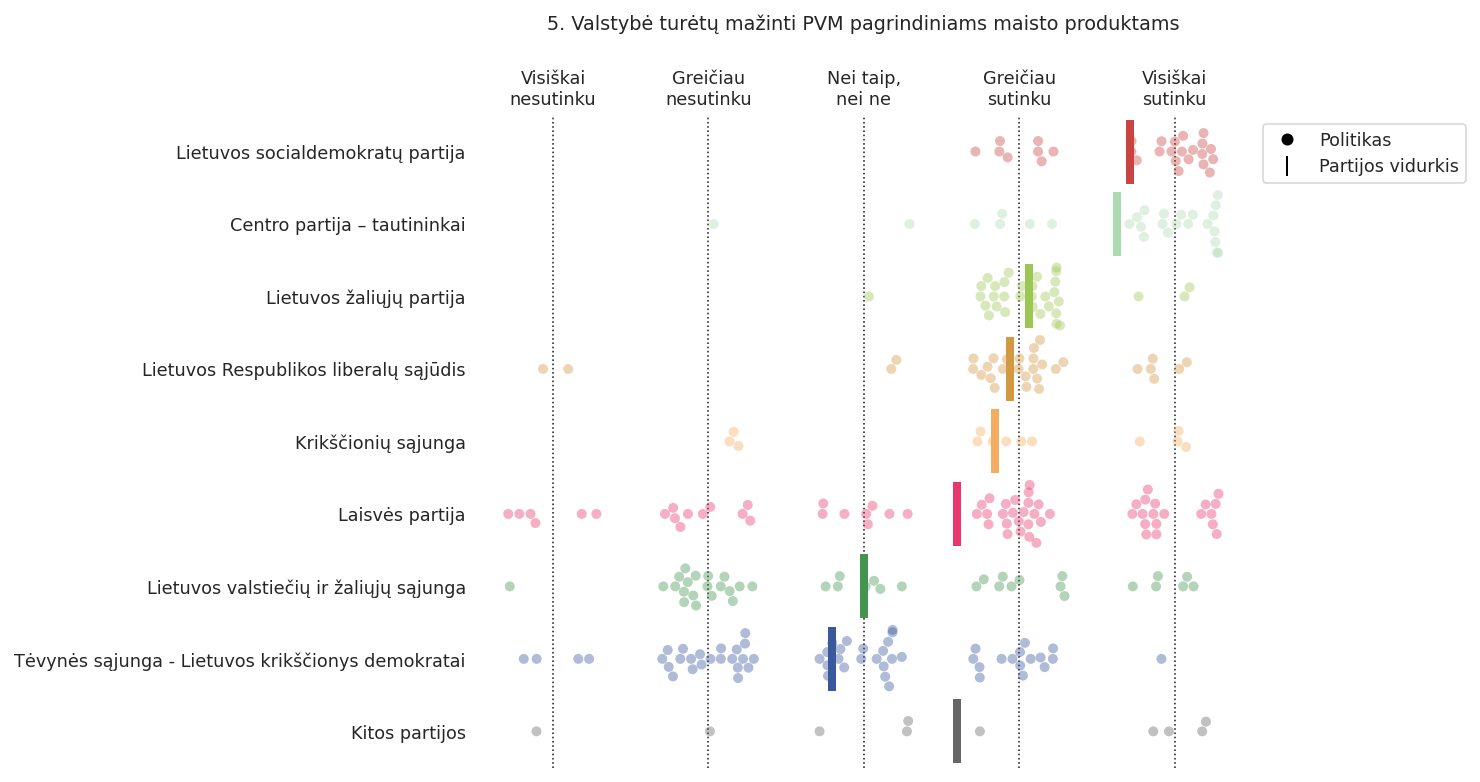

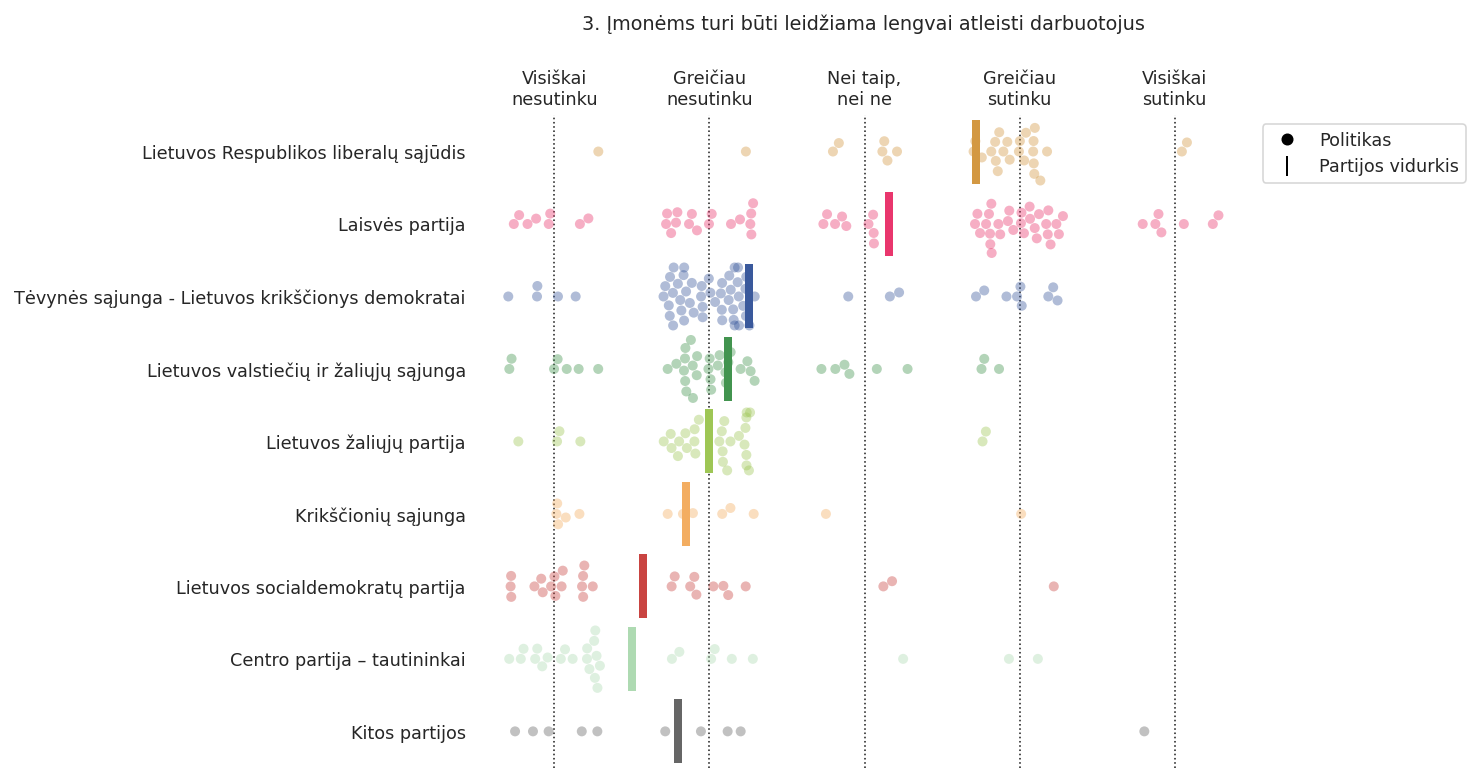

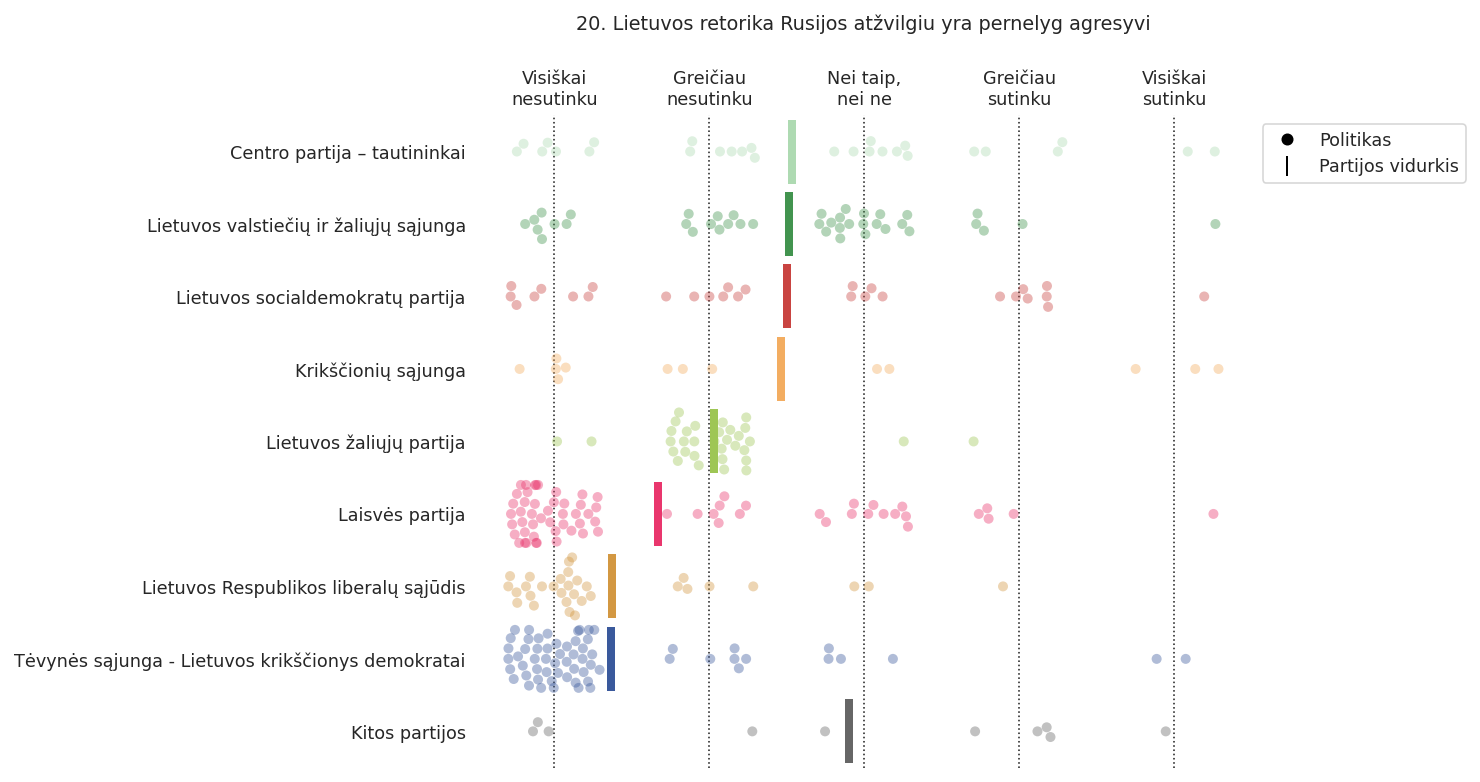

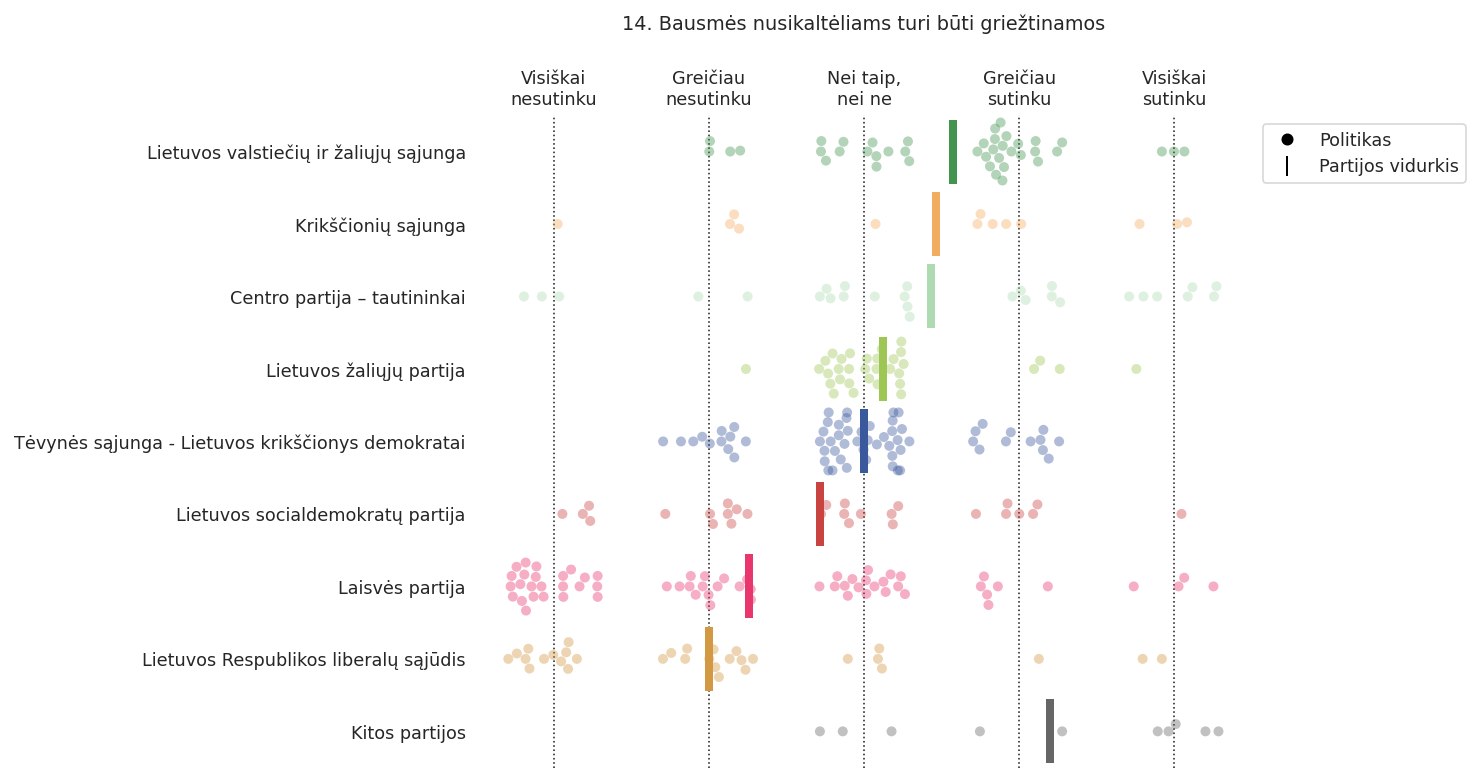

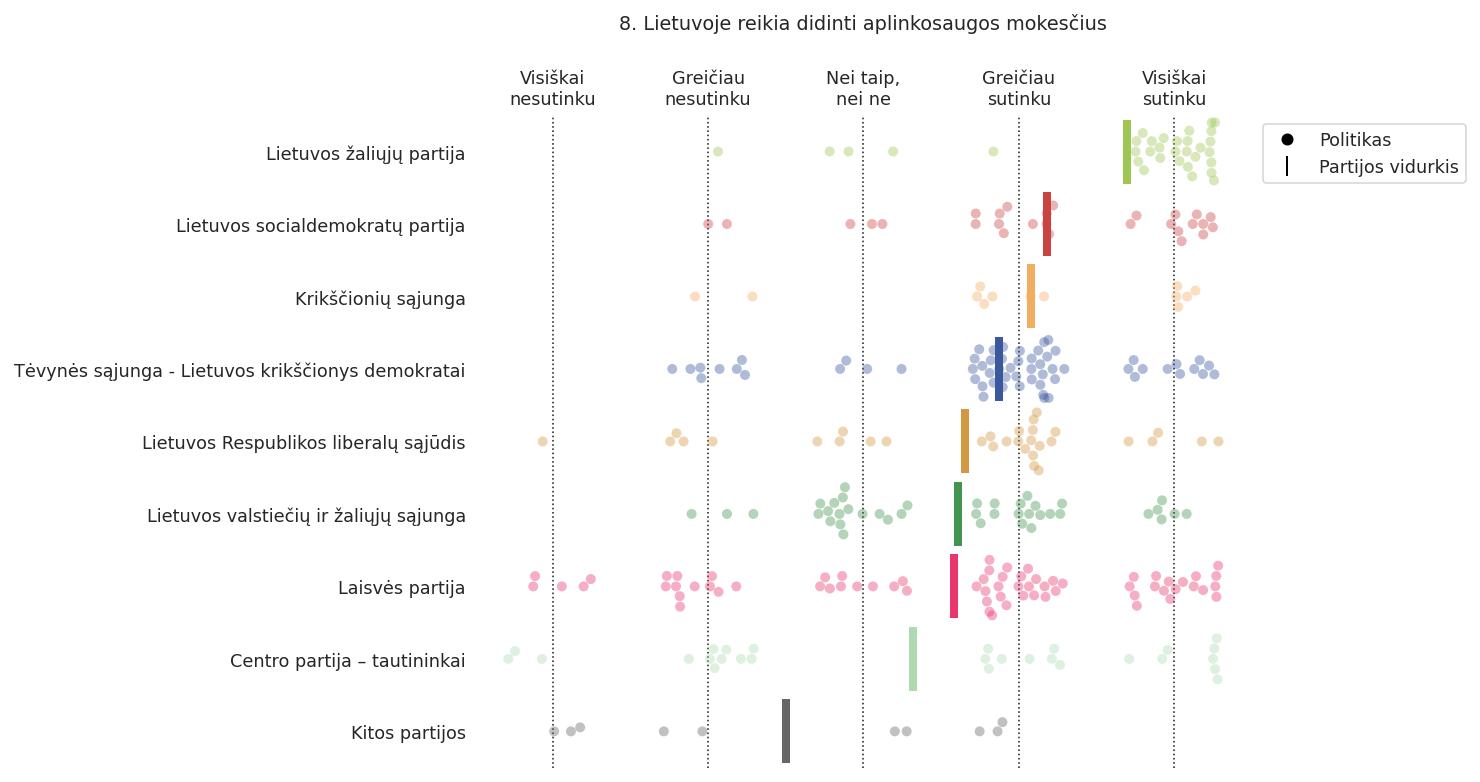

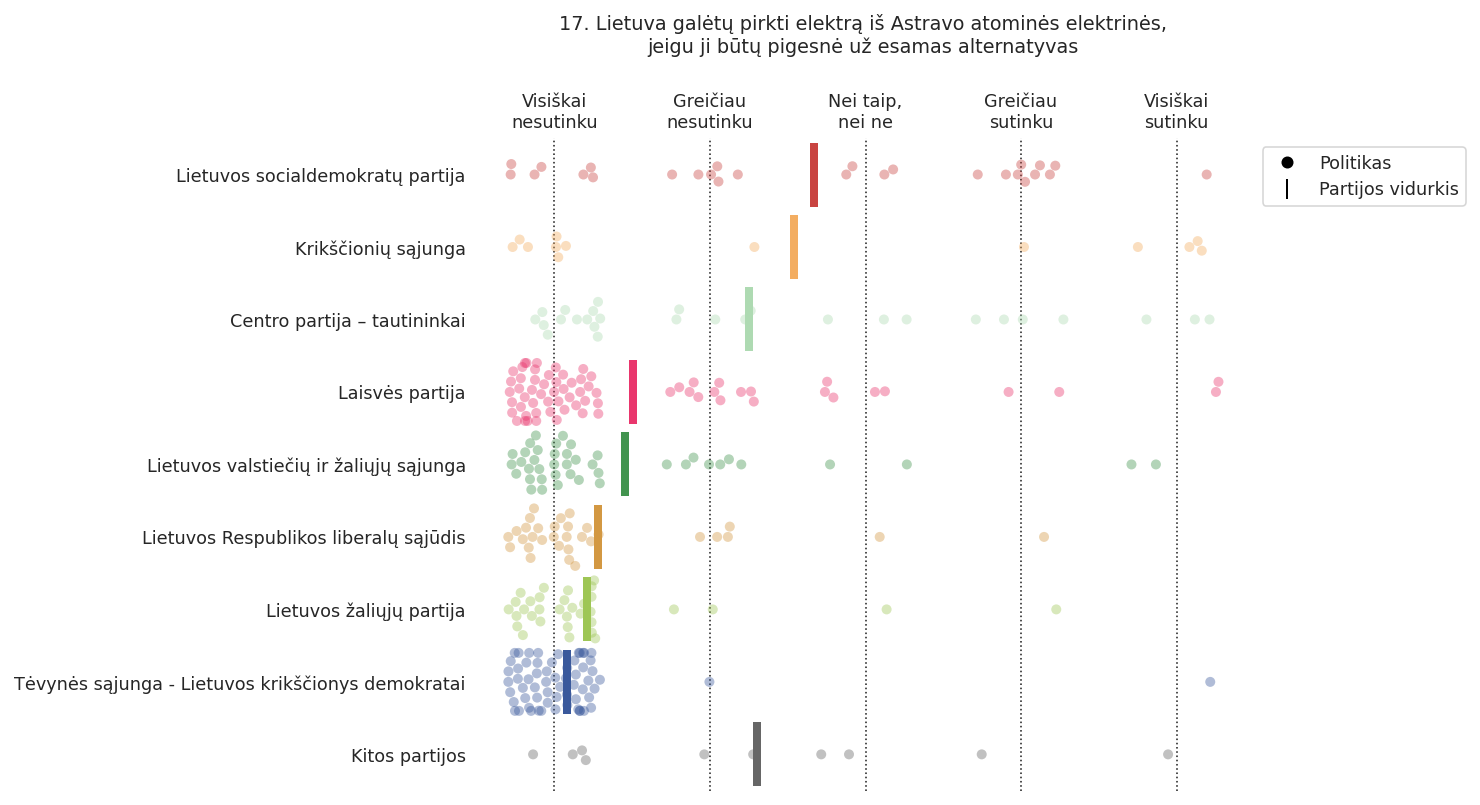

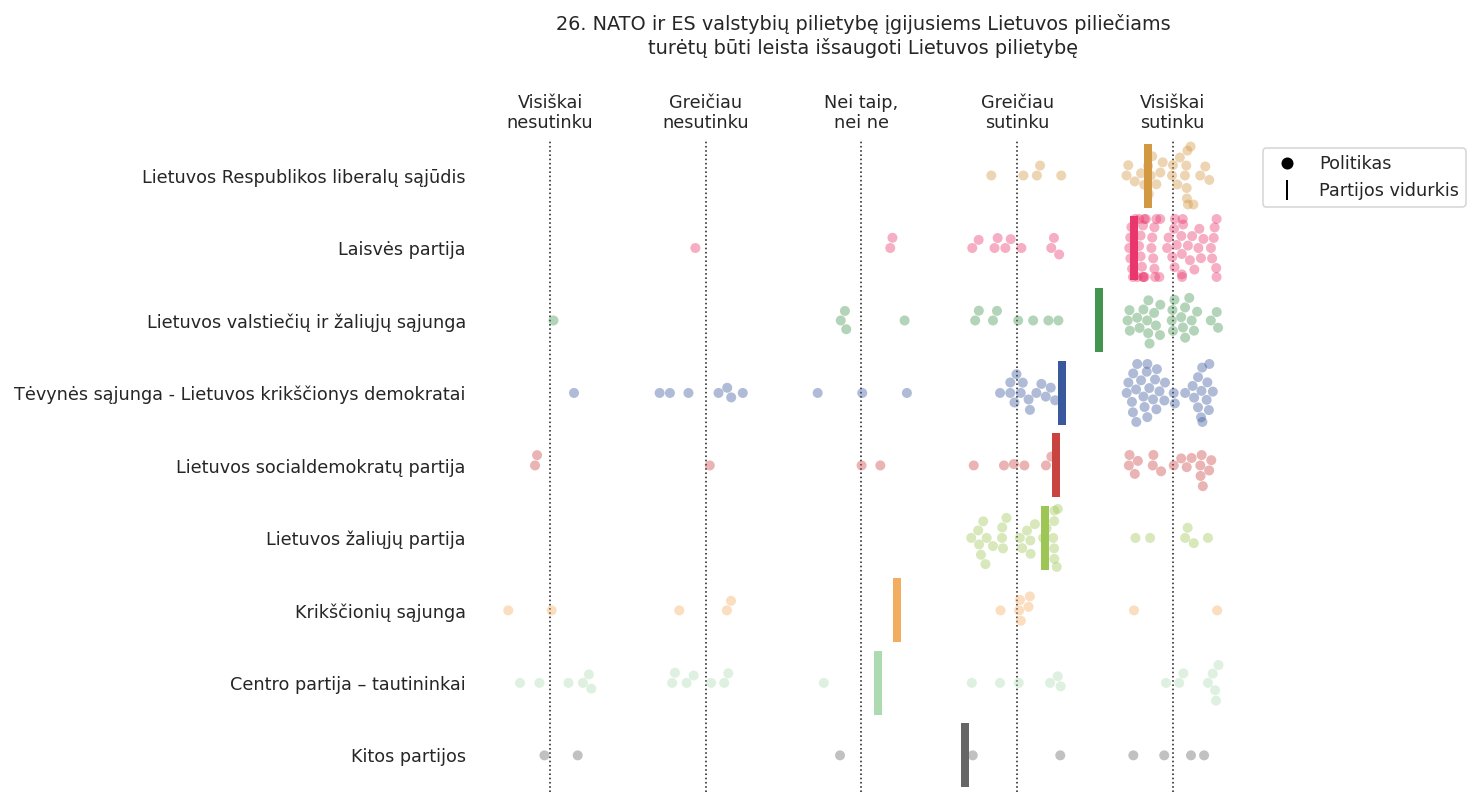

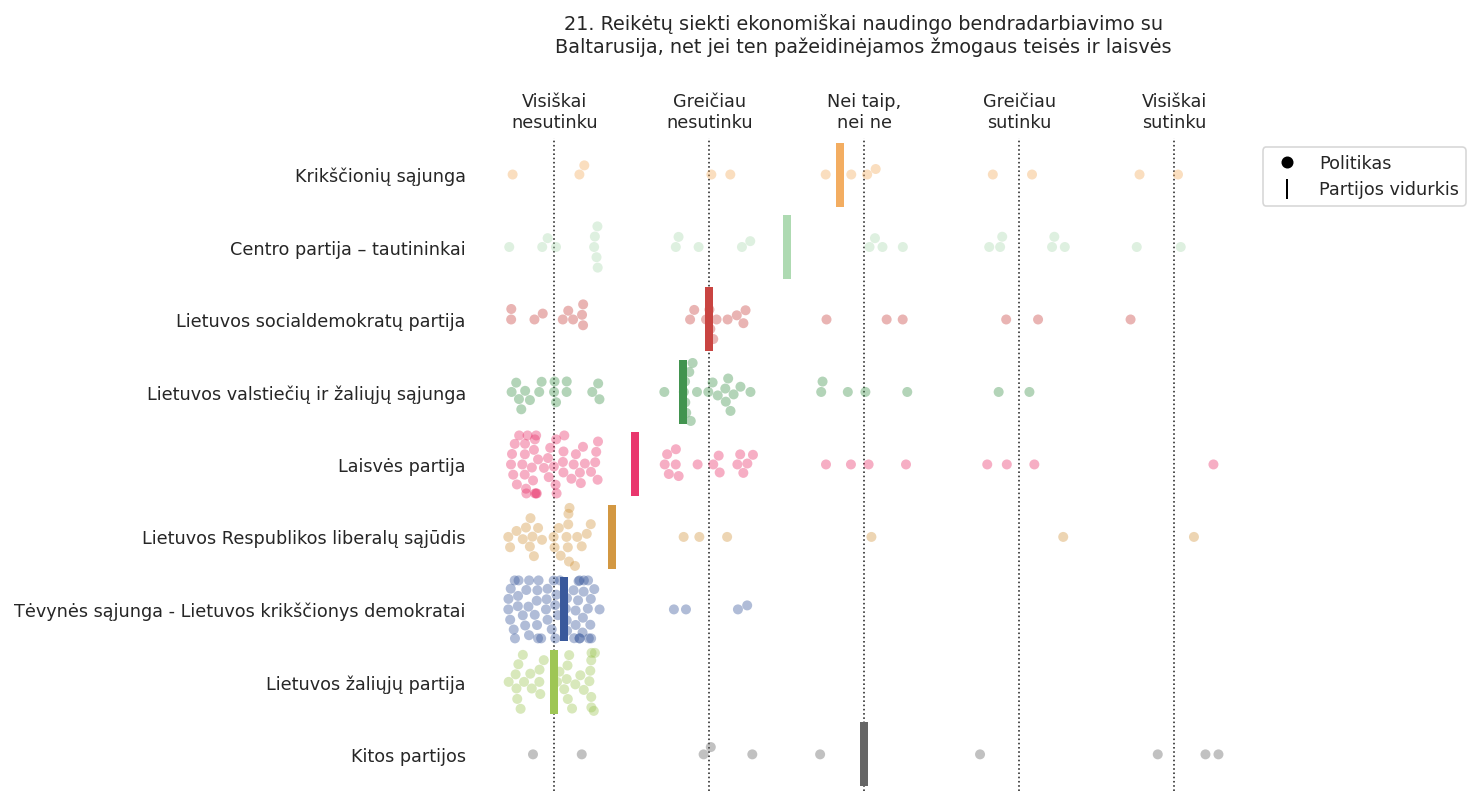

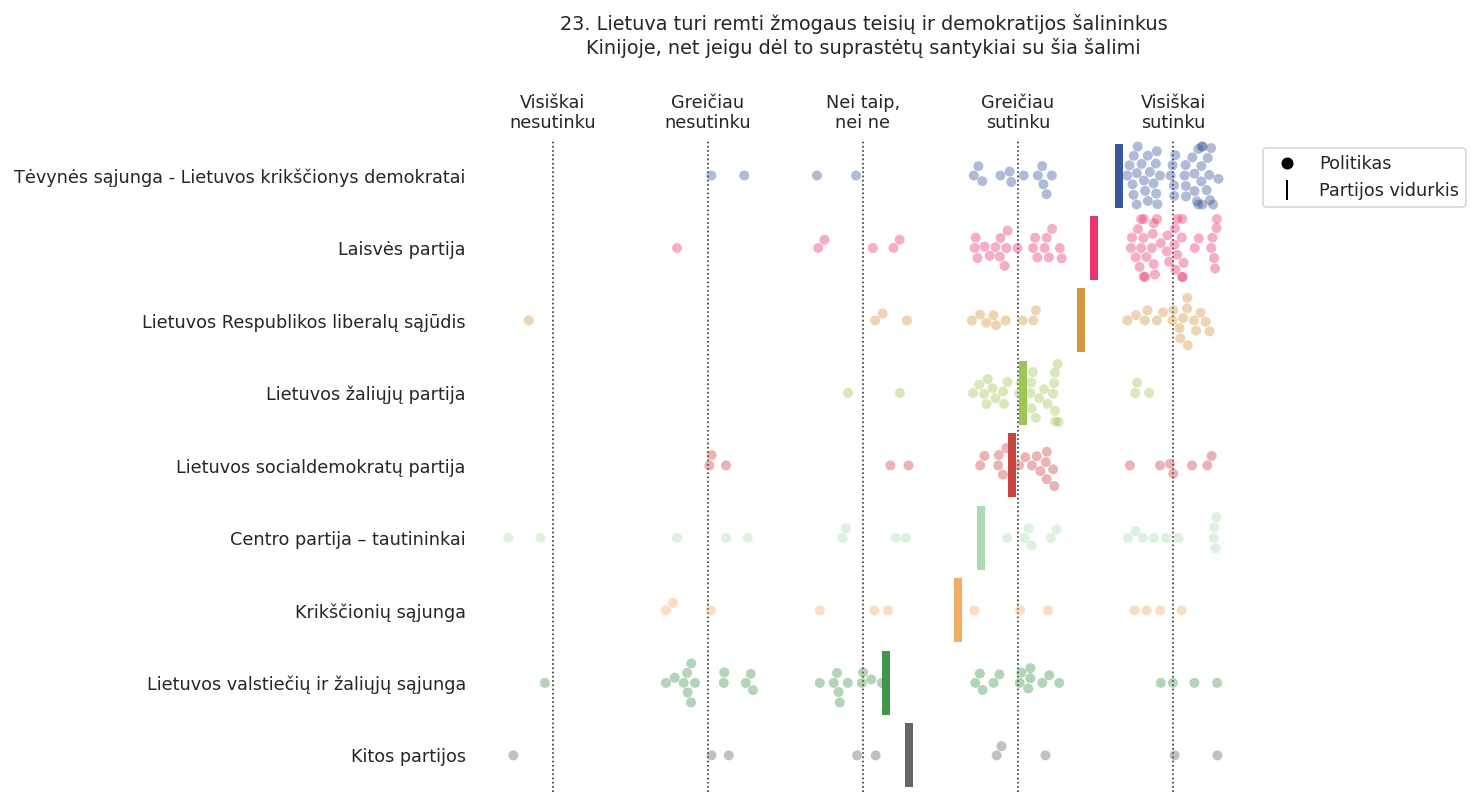

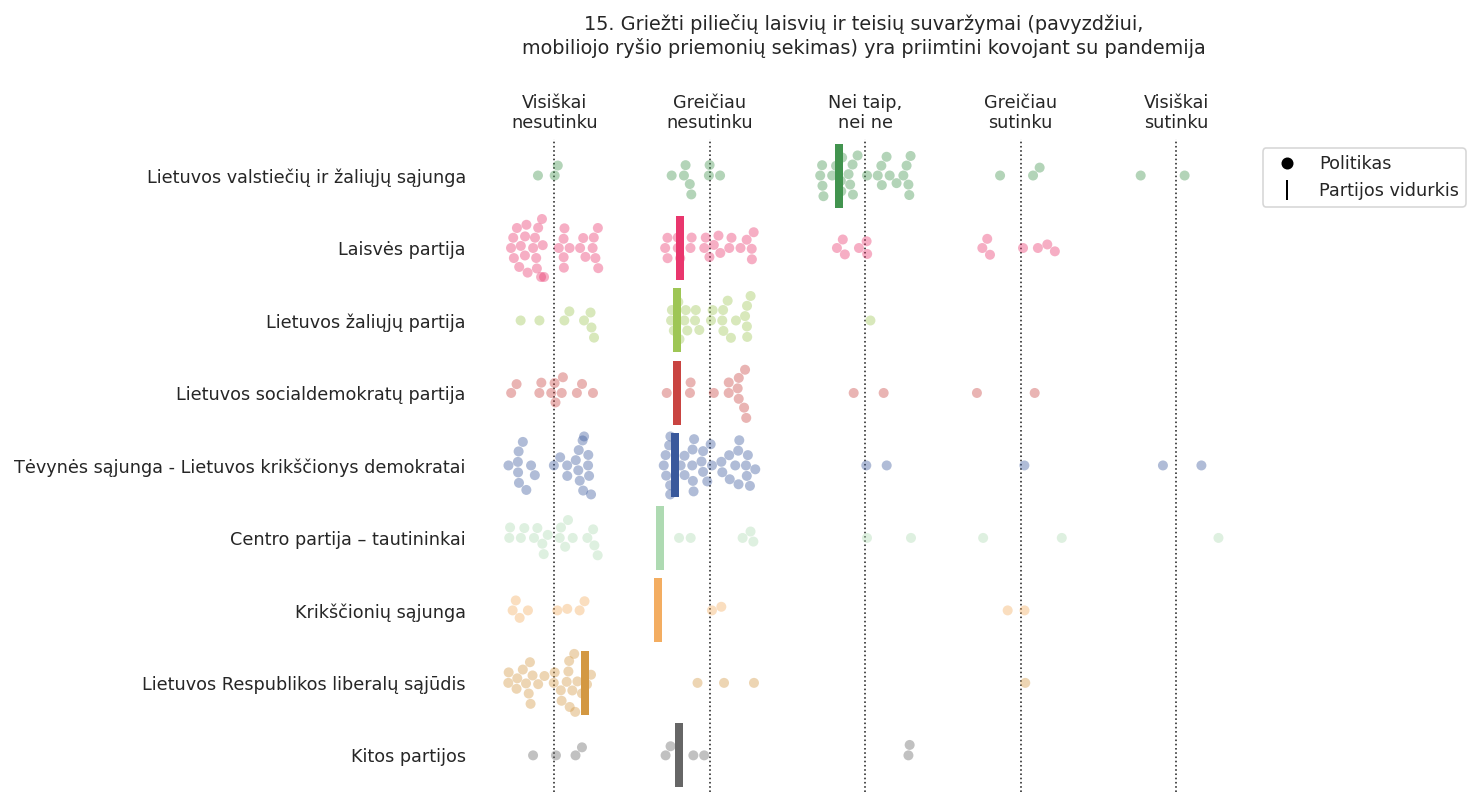

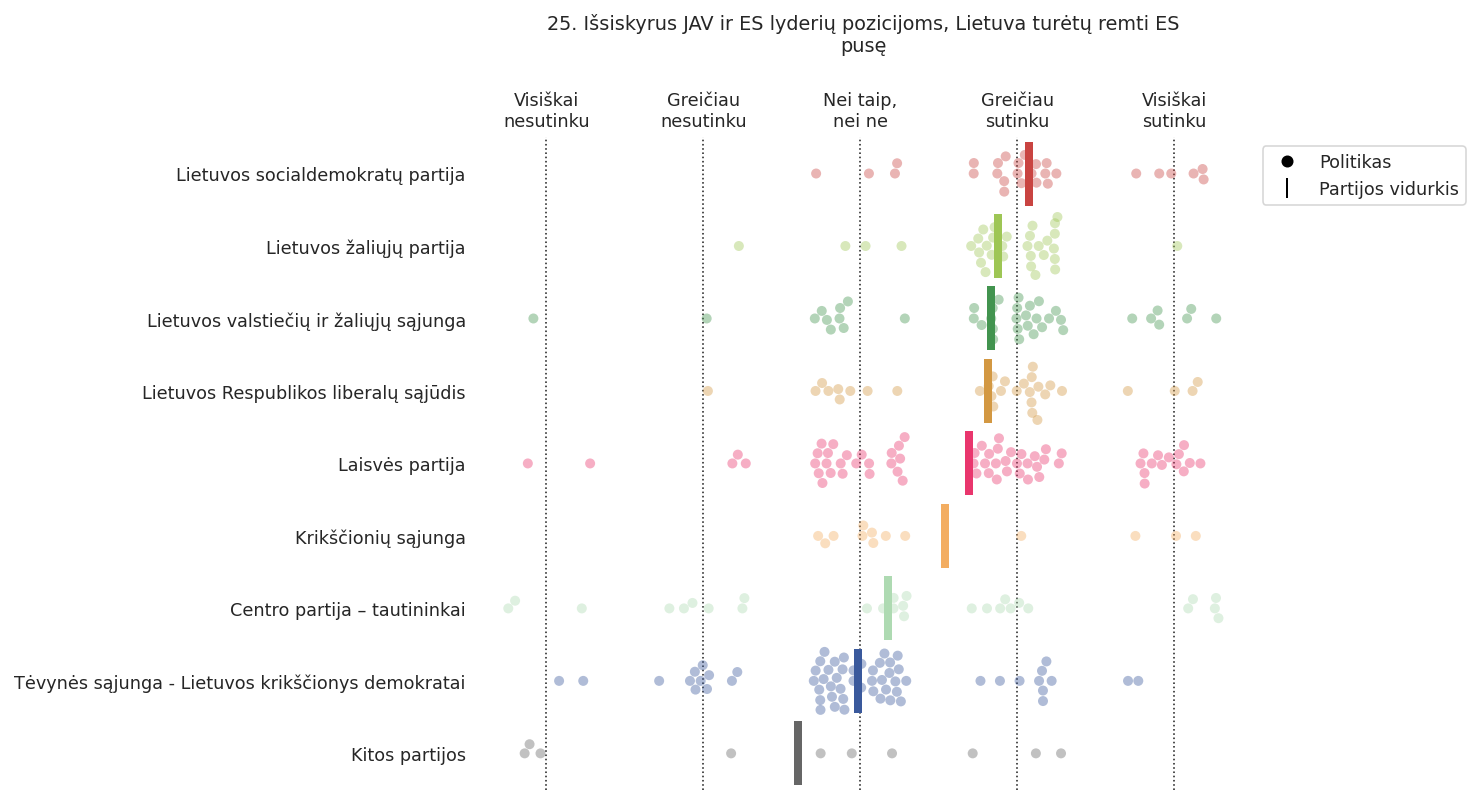

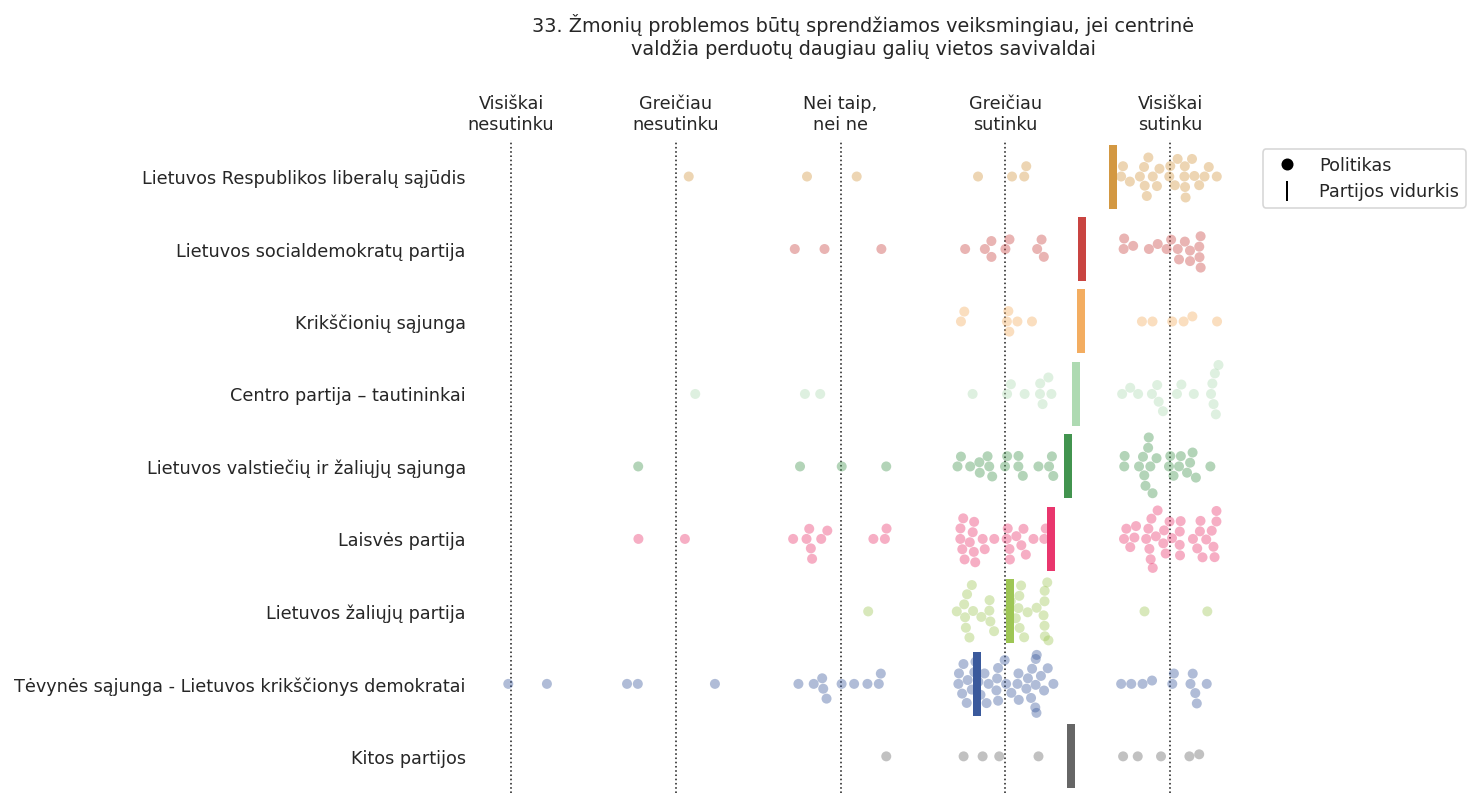

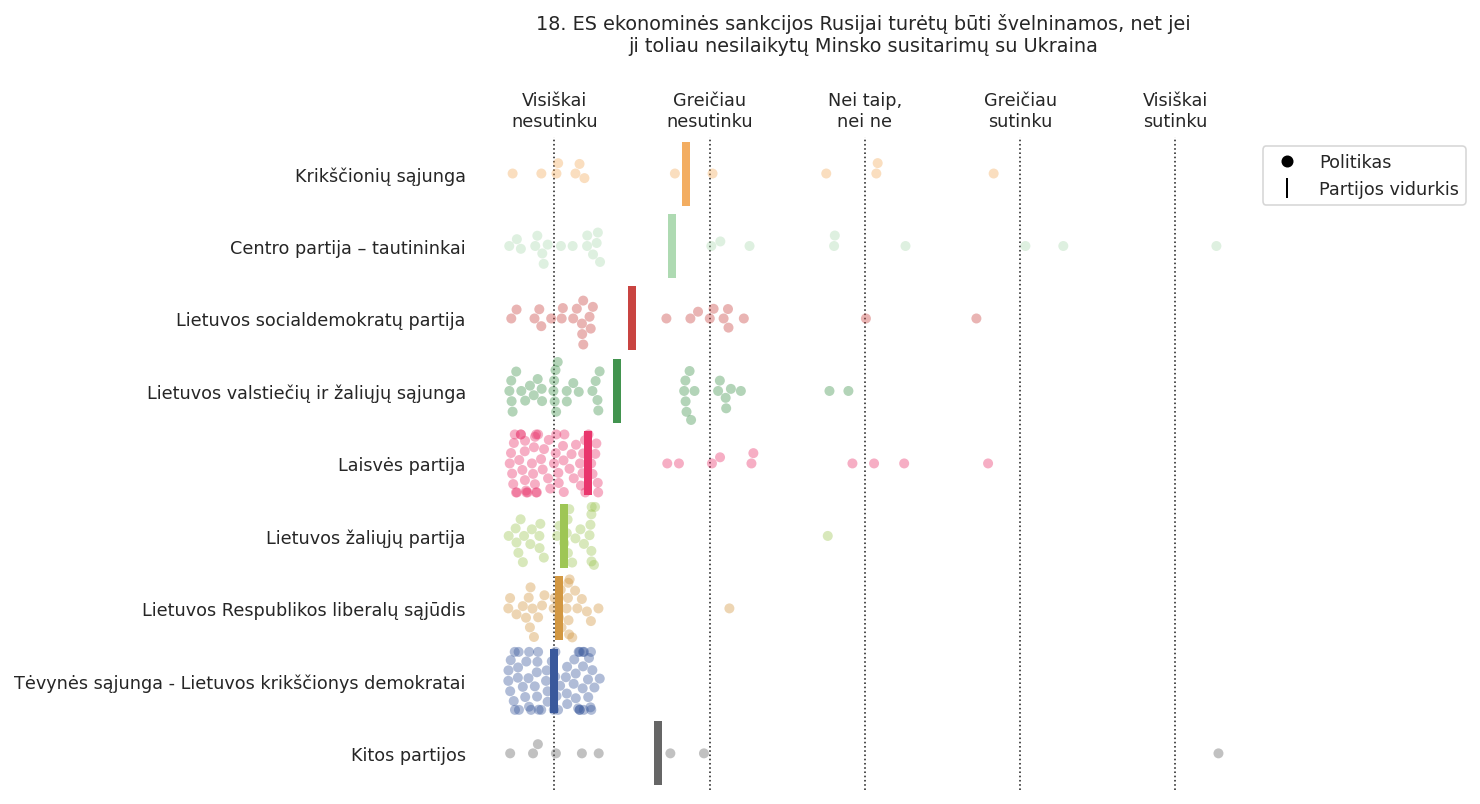

In [60]:
for question in variance_order:

    random = np.random.RandomState(42)

    _df = data.reset_index()
    _df = _df[_df['question'] == question]

    _df['answer_code_with_jitter'] = _df['answer_code'] + random.uniform(-0.3, 0.3, size=len(_df))

    x_order = list(_df.groupby('grouped_party')['answer_code'].mean().sort_values(ascending=False).index)
    # Move "Kitos partijos" to the back
    x_order = [p for p in x_order if p != 'Kitos partijos'] + ['Kitos partijos']

    fig = plt.figure(figsize=(7, 6))
    ax = plt.gca()

    means = _df.groupby('grouped_party')['answer_code'].mean()

    lines = []

    for party, mean in means.items():

        try:
            party_index = x_order.index(party)
        except ValueError:
            continue



        ax.scatter(mean, party_index, marker='|', s=1000, 
                   linewidths=4,
                   color=PARTY_COLOR[party])


    sns.swarmplot(x='answer_code_with_jitter', 
                  y='grouped_party',
                  hue='grouped_party',
                  palette=PARTY_COLOR,
                  dodge=False, 
                  order=x_order,
                  ax=ax,
                  alpha=0.4,
                  linewidths=1.0,
                  data=_df)

    legend_dot = Line2D([],[], color='black', marker='o', 
                        linestyle='None',
                        markersize=5, 
                        label='Politikas')

    legend_mean = Line2D([],[], color='black', marker='|', 
                        linestyle='None',
                        markersize=10,
                        linewidth=5,
                        label='Partijos vidurkis')

    ax.legend(handles=[legend_dot, legend_mean], loc='upper left', bbox_to_anchor=(1, 1))
    # ax.legend_.set_visible(False)
    sns.despine(ax=ax, bottom=True, left=True, offset=5)
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    ax.set_title('\n'.join(textwrap.wrap(question, 70)), pad=20)
    ax.set_xticks(ORDERED_ANSWER_CODES)
    ax.set_xticklabels([ans.replace(' ', '\n') if ans != 'Nei taip, nei ne' else 'Nei taip,\nnei ne' for ans in ORDERED_ANSWERS])
    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.xaxis.tick_top()
    
    question_number = int(question.partition('.')[0])
    plt.savefig(os.path.join(OUTDIR, f'klausimas-{question_number}.pdf'), bbox_inches='tight')
    


Kurie politikai nepritaria ES sankcijoms rusijai?

In [39]:
_question = variance_order[-1]
print(_question)
_df = data.loc(axis=0)[:, :, _question]
_df = _df.query('answer_code > 0')


party_order = _df.reset_index().groupby('party')['member_name'].nunique().sort_values(ascending=False).index


for party in party_order:
    
    subdf = _df[_df['party'] == party].reset_index().sort_values(by='member_name')
    print(f'{party}:')
    
    for __, row in subdf.iterrows():
        print('* {} ({})'.format(row['member_name'], row['answer']))
    

    print()

_df = _df[~_df['comment'].isnull()]
if not _df.empty:
    print("Šie žmonės nusprendė pakomentuoti:")
    
    for __, row in _df.reset_index().iterrows():
        print('* {} ({}):'.format(row['member_name'], row['party']))
        print(row['comment'])
    

18. ES ekonominės sankcijos Rusijai turėtų būti švelninamos, net jei ji toliau nesilaikytų Minsko susitarimų su Ukraina
Centro partija – tautininkai:
* Alfonsas Lupeikis (Visiškai sutinku)
* Daiva Kazakevičiūtė (Greičiau sutinku)
* Nerijus Meškauskas (Greičiau sutinku)

Lietuvos socialdemokratų partija:
* Valentin Gavrilov (Greičiau sutinku)

Lietuvos liaudies partija:
* Darius Gruzdys (Visiškai sutinku)

Laisvės partija:
* Algis Bitautas (Greičiau sutinku)

Krikščionių sąjunga:
* Gediminas Akelaitis (Greičiau sutinku)

Šie žmonės nusprendė pakomentuoti:
* Valentin Gavrilov (Lietuvos socialdemokratų partija):
Sankcijos neturi būti naudojamos kaip savo jėgos parodymas. Akivaizdu, kad ekonominės sankcijos Rusijai nepadeda pasiekti norimo rezultato, todėl reikia keisti požiūrį. Pagrindinis tikslas – užbaigti kruviną konfliktą, o ne priversti Rusiją pasitraukti ir pralaimėti.


In [50]:
_question = variance_order[1]
print(_question)
_df = data.loc(axis=0)[:, :, _question]
_df = _df.query('answer_code <= 0')

_df = _df.loc[['Laisvės partija', 'Lietuvos Respublikos liberalų sąjūdis']]


party_order = _df.reset_index().groupby('party')['member_name'].nunique().sort_values(ascending=False).index


for party in party_order:
    
    subdf = _df[_df['party'] == party].reset_index().sort_values(by='member_name')
    print(f'{party}:')
    
    for __, row in subdf.iterrows():
        print('* {} ({})'.format(row['member_name'], row['answer']))
    

    print()

_df = _df[~_df['comment'].isnull()]
if not _df.empty:
    print("Šie žmonės nusprendė pakomentuoti:")
    
    for __, row in _df.reset_index().iterrows():
        print('* {} ({}):'.format(row['member_name'], row['party']))
        print(row['comment'])
    

11. Tos pačios lyties asmenų poros turi turėti tokias pat teises tuoktis kaip ir heteroseksualios poros
Lietuvos Respublikos liberalų sąjūdis:
* Benediktas Krasniauskas (Nei taip, nei ne)
* Dalius Dirsė (Nei taip, nei ne)
* Kęstutis Bagdanavičius (Greičiau nesutinku)
* Mindaugas Sargūnas (Visiškai nesutinku)
* Nijolė Makštutienė (Nei taip, nei ne)
* Ričardas Leckas (Nei taip, nei ne)
* Saulius Budinas (Greičiau nesutinku)
* Saulius Liekis (Nei taip, nei ne)

Laisvės partija:
* Gražvyda Petrikaitė (Nei taip, nei ne)
* Jurgita Jokūbaitytė (Nei taip, nei ne)
* Vida Navickienė (Greičiau nesutinku)

Šie žmonės nusprendė pakomentuoti:
* Gražvyda Petrikaitė (Laisvės partija):
Paremčiau tos pačios lyties asmenų porų partnerystės įteisinimą.
* Benediktas Krasniauskas (Lietuvos Respublikos liberalų sąjūdis):
Tobulinti ir įteisinti visapusišką partnerystės institutą.


In [56]:
_question = variance_order[1]
print(_question)
_df = data.loc(axis=0)[:, :, _question]
_df = _df.query('answer_code > 0')

_df = _df.loc[['Tėvynės sąjunga - Lietuvos krikščionys demokratai', 
               'Lietuvos valstiečių ir žaliųjų sąjunga']]


party_order = _df.reset_index().groupby('party')['member_name'].nunique().sort_values(ascending=False).index


for party in party_order:
    
    subdf = _df[_df['party'] == party].reset_index().sort_values(by='member_name')
    print(f'{party}:')
    
    for __, row in subdf.iterrows():
        print('* {} ({})'.format(row['member_name'], row['answer']))
    

    print()

_df = _df[~_df['comment'].isnull()]
if not _df.empty:
    print("Šie žmonės nusprendė pakomentuoti:")
    
    for __, row in _df.reset_index().iterrows():
        print('* {} ({}):'.format(row['member_name'], row['party']))
        print(row['comment'])
    

11. Tos pačios lyties asmenų poros turi turėti tokias pat teises tuoktis kaip ir heteroseksualios poros
Tėvynės sąjunga - Lietuvos krikščionys demokratai:
* Aistė Gedvilienė (Greičiau sutinku)
* Birutė Kažemėkaitė (Greičiau sutinku)
* Dalius Krinickas (Visiškai sutinku)
* Jurgita Sejonienė (Greičiau sutinku)
* Justinas Pranys (Greičiau sutinku)
* Kristijonas Bartoševičius (Greičiau sutinku)
* Kęstutis Navickas (Greičiau sutinku)
* Matas Maldeikis (Visiškai sutinku)
* Paulė Kuzmickienė (Greičiau sutinku)
* Radvilė Morkūnaitė-Mikulėnienė (Greičiau sutinku)
* Skaidra Dišlė (Visiškai sutinku)

Lietuvos valstiečių ir žaliųjų sąjunga:
* Agnė Prušinskaitė (Greičiau sutinku)
* Aušra Papirtienė (Greičiau sutinku)
* Liutauras Vičkačka (Greičiau sutinku)
* Martynas Norbutas (Visiškai sutinku)
* Tautvydas Tamulevičius (Visiškai sutinku)
* Tomas Tomilinas (Greičiau sutinku)

Šie žmonės nusprendė pakomentuoti:
* Aistė Gedvilienė (Tėvynės sąjunga - Lietuvos krikščionys demokratai):
Palaikau partnerys

In [75]:
_question = variance_order[1]
print(_question)
_df = data.loc(axis=0)[:, :, _question]
_df = _df.query('answer_code < 2')

_df = _df.loc[['Lietuvos socialdemokratų partija']]


party_order = _df.reset_index().groupby('party')['member_name'].nunique().sort_values(ascending=False).index


for party in party_order:
    
    subdf = _df[_df['party'] == party].reset_index().sort_values(by='member_name')
    print(f'{party}:')
    
    for __, row in subdf.iterrows():
        print('* {} ({})'.format(row['member_name'], row['answer']))
    

    print()

_df = _df[~_df['comment'].isnull()]
if not _df.empty:
    print("Šie žmonės nusprendė pakomentuoti:")
    
    for __, row in _df.reset_index().iterrows():
        print('* {} ({}):'.format(row['member_name'], row['party']))
        print(row['comment'])
    

11. Tos pačios lyties asmenų poros turi turėti tokias pat teises tuoktis kaip ir heteroseksualios poros
Lietuvos socialdemokratų partija:
* Alfonsas Brazas (Nei taip, nei ne)
* Algirdas Sysas (Greičiau sutinku)
* Arūnas Dudėnas (Greičiau nesutinku)
* Dainius Žiogelis (Visiškai nesutinku)
* Daiva Riklienė (Greičiau nesutinku)
* Kęstutis Jacunskas (Greičiau nesutinku)
* Kęstutis Vilkauskas (Visiškai nesutinku)
* Lina Maižiuvienė (Greičiau sutinku)
* Ramūnas Lydis (Greičiau sutinku)
* Saulius Sondeckis (Greičiau nesutinku)
* Tomas Budrikis (Greičiau nesutinku)
* Tomas Martinaitis (Nei taip, nei ne)
* Valentin Gavrilov (Greičiau nesutinku)
* Vidmantas Kanopa (Greičiau nesutinku)

Šie žmonės nusprendė pakomentuoti:
* Alfonsas Brazas (Lietuvos socialdemokratų partija):
Pasisakau už tos pačios lyties asmenų PARTNERYSTĖS, kuri nėra prilyginama santuokai, įteisinimą.
* Daiva Riklienė (Lietuvos socialdemokratų partija):
Žmonių požiūris į šeimą keičiasi. Daug porų gyvena, augina vaikus, nesusituo